In [1]:
%run lattice_gen.py

single layer Hamiltonian done
4 layer Hamiltonian done
fractal done
wavepacket done


In [2]:
def find_largest_imE(Lx, Ly, t, m_vals, gamma, T, Ts, To):
        
    H_all = H_four_layer_Lx_Ly_all(Lx, Ly, t, m_vals, gamma, T, Ts, To)

    H_dense = H_all.todense()
    H_dense_np = np.array(H_dense)
    H_tensor = torch.tensor(H_dense_np, dtype=torch.complex128)

    H_dense_memory = H_dense_np.data.nbytes / 1e9
    print(f"Memory usage of dense matrix: {H_dense_memory:.6f} GB")
    H_tensor_memory = H_tensor.data.element_size() * H_tensor.numel() / 1e9
    print(f"Memory usage of dense tensor: {H_tensor_memory:.6f} GB")
    # Compute the eigenvalues
    E, V = torch.linalg.eig(H_tensor)
    sorted_indices_re = np.argsort(np.real(E))
    E_sort_re = E[sorted_indices_re]
    V_sort_re = V[:, sorted_indices_re]
    sorted_indices_re = np.argsort(np.real(E))
    E_sort_re = E[sorted_indices_re]
    V_sort_re = V[:, sorted_indices_re]

    IPR_values_copy1= []
    IPR_values_copy2= []

    for n0 in range(len(E_sort_re)):
        V1 = np.zeros((Lx * Ly, 1), dtype=complex)
        V2 = np.zeros((Lx * Ly, 1), dtype=complex)
        V3 = np.zeros((Lx * Ly, 1), dtype=complex)
        V4 = np.zeros((Lx * Ly, 1), dtype=complex)


        for i in range(Lx * Ly):
            V1[i, 0] = abs(V_sort_re[2 * i, n0] ** 2) + abs(V_sort_re[2 * i + 1, n0] ** 2)
            V2[i, 0] = abs(V_sort_re[2 * i + 2 * Lx * Ly, n0] ** 2) + abs(V_sort_re[2 * i + 1 + 2 * Lx * Ly, n0] ** 2)
            V3[i, 0] = abs(V_sort_re[2 * i + 4 * Lx * Ly, n0] ** 2) + abs(V_sort_re[2 * i + 1 + 4 * Lx * Ly, n0] ** 2)
            V4[i, 0] = abs(V_sort_re[2 * i + 6 * Lx * Ly, n0] ** 2) + abs(V_sort_re[2 * i + 1 + 6 * Lx * Ly, n0] ** 2)

        eigenstate_1 = np.reshape(V1, (Ly, Lx))
        eigenstate_2 = np.reshape(V2, (Ly, Lx))
        eigenstate_3 = np.reshape(V3, (Ly, Lx))
        eigenstate_4 = np.reshape(V4, (Ly, Lx))

        IPR12 = abs(np.sum(eigenstate_1[0,:]))/abs(np.sum(eigenstate_1))+abs(np.sum(eigenstate_1[Ly-1,:]))/abs(np.sum(eigenstate_1)) + abs(np.sum(eigenstate_2[0,:]))/abs(np.sum(eigenstate_2))+abs(np.sum(eigenstate_2[Ly-1,:]))/abs(np.sum(eigenstate_2))
        
        IPR12 = IPR12 - (1-IPR12) / (2*Lx*Ly - 4*Lx - 2*Ly + 4) * (4*Lx + 2*Ly - 4)

        IPR34 = abs(np.sum(eigenstate_3[0,:]))/abs(np.sum(eigenstate_3))+abs(np.sum(eigenstate_3[Ly-1,:]))/abs(np.sum(eigenstate_3)) + abs(np.sum(eigenstate_4[0,:]))/abs(np.sum(eigenstate_4))+abs(np.sum(eigenstate_4[Ly-1,:]))/abs(np.sum(eigenstate_4))
        
        IPR34 = IPR34 - (1-IPR34) / (2*Lx*Ly - 4*Lx - 2*Ly + 4) * (4*Lx + 2*Ly - 4)

        IPR_values_copy1.append(IPR12)
        IPR_values_copy2.append(IPR34)

    # Convert IPR values to colors
    colors_copy1 = np.array(IPR_values_copy1)
    colors_copy2 = np.array(IPR_values_copy2)

    colors = (colors_copy1 + colors_copy2) / 4

    E_sort_re = np.asarray(E_sort_re)
    colors = np.asarray(colors)

    # 筛选 bulk states
    mask_bulk = (colors < 0.25)
    filtered_bulk = np.imag(E_sort_re[mask_bulk])

    # 筛选 topo states, ReE 在 -0.4 到 0.4 之间,ImE最大的那个
    
    mask_topo = (np.real(E_sort_re) > -0.9) & (np.real(E_sort_re) < 0.9) & (colors > 0.6)
    filtered_topo = np.imag(E_sort_re[mask_topo])

    # 计算最大 ImE，并找到对应索引
    if filtered_bulk.size > 0:
        max_bulk_idx = np.argmax(filtered_bulk)  # 局部索引
        imE_max_bulk = filtered_bulk[max_bulk_idx]
        global_bulk_idx = np.where(mask_bulk)[0][max_bulk_idx]  # 获取全局索引
    else:
        imE_max_bulk = np.nan
        global_bulk_idx = None

    if filtered_topo.size > 0:
        max_topo_idx = np.argmax(filtered_topo)  # 局部索引
        imE_max_topo = filtered_topo[max_topo_idx]
        global_topo_idx = np.where(mask_topo)[0][max_topo_idx]  # 获取全局索引
    else:
        imE_max_topo = np.nan
        global_topo_idx = None

    # 计算差值
    imE_diff = imE_max_topo - imE_max_bulk


        # Create the scatter plot
    scatter = plt.scatter(np.real(E_sort_re), np.imag(E_sort_re), s=30, marker='s', c=colors, cmap='rainbow', vmin = 0, vmax = 0.8)
    # plot max_bulk_idx and max_topo_idx
    if global_bulk_idx is not None:
        plt.scatter(np.real(E_sort_re[global_bulk_idx]), np.imag(E_sort_re[global_bulk_idx]), s=100, marker='o', c='black', label='max bulk')
    if global_topo_idx is not None:
        plt.scatter(np.real(E_sort_re[global_topo_idx]), np.imag(E_sort_re[global_topo_idx]), s=100, marker='x', c='black', label='max topo')
    colorbar = plt.colorbar(scatter)
    colorbar.ax.set_ylabel('Edge occ. ratio', rotation=270, fontsize=24, labelpad=24)
    colorbar.ax.tick_params(labelsize=24)
    plt.xlabel('Re[$E$]', fontsize=25)
    plt.ylabel('Im[$E$]', fontsize=25)
    # plt.ylim(-0.025, 0.025)
    plt.title(rf'$L_x={Lx}, L_y={Ly}, \mu_s = {np.round(Ts,3)}, \mu_o={np.round(To,3)}$', fontsize=24)
    plt.xticks(fontsize=24)
    plt.yticks(fontsize=24)
    plt.show()

    
    return imE_max_bulk, imE_max_topo, imE_diff


In [3]:
Lx = 20
Ly = 6
t = np.ones((Ly, Lx))

num = 10
gamma00_vals = np.linspace(0.0, 0.2, num)
m00_vals     = np.linspace(1, 1.2, num)


T = 0

Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


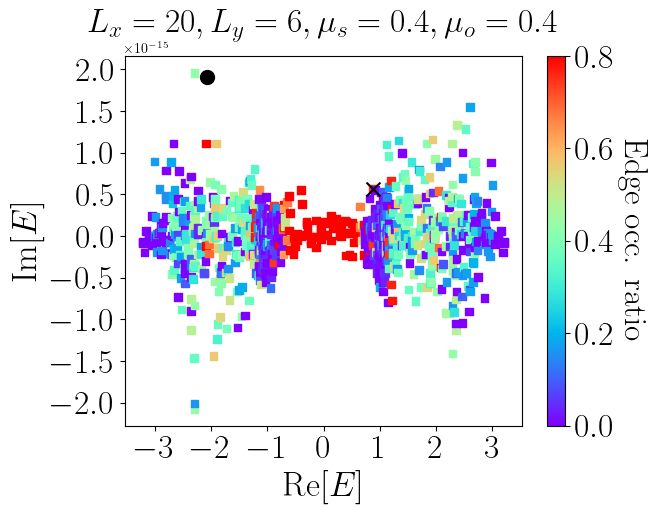

m = 1.0, gamma = 0.0, imE_max_bulk = 1.912264930662713e-15, imE_max_topo = 5.626700275073302e-16, imE_diff = -1.3495949031553827e-15
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


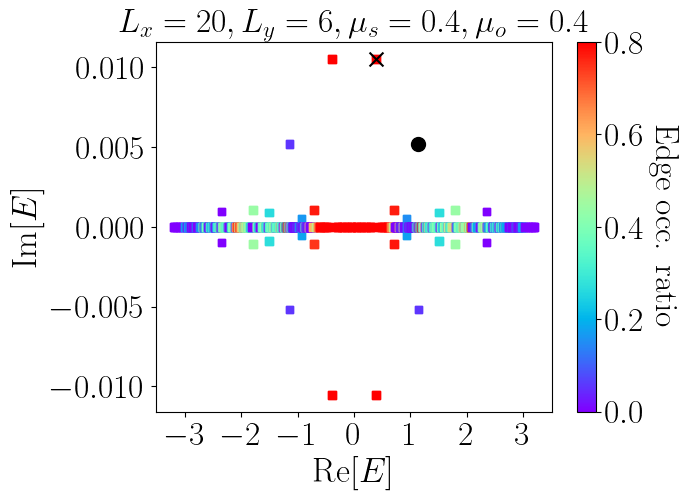

m = 1.0, gamma = 0.022222222222222223, imE_max_bulk = 0.005186102056287788, imE_max_topo = 0.010529507516940852, imE_diff = 0.005343405460653063
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


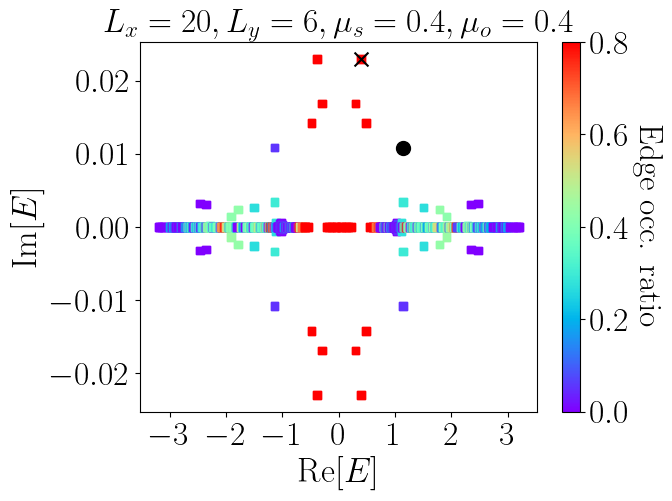

m = 1.0, gamma = 0.044444444444444446, imE_max_bulk = 0.010852093146186315, imE_max_topo = 0.02297738460523077, imE_diff = 0.012125291459044453
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


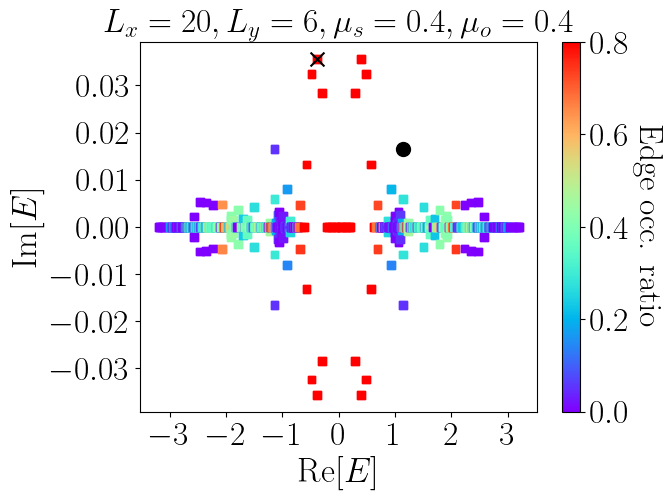

m = 1.0, gamma = 0.06666666666666667, imE_max_bulk = 0.016561948216211868, imE_max_topo = 0.03564327779721061, imE_diff = 0.019081329580998743
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


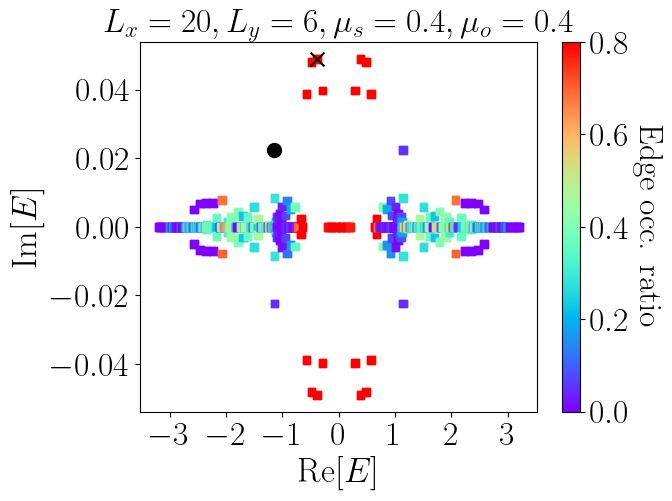

m = 1.0, gamma = 0.08888888888888889, imE_max_bulk = 0.02237178699675832, imE_max_topo = 0.049032940733951536, imE_diff = 0.026661153737193216
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


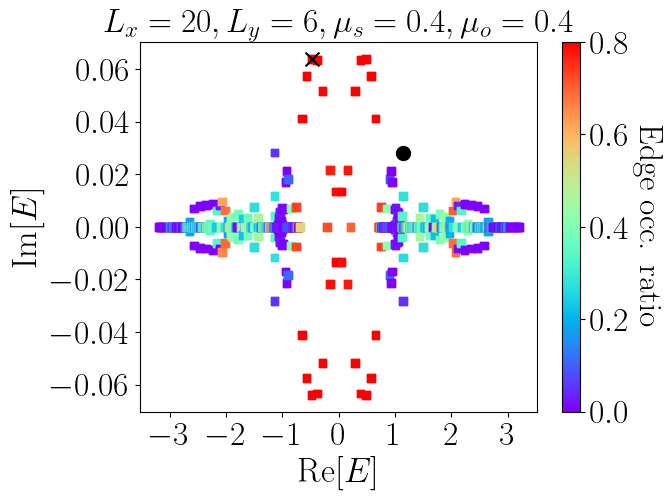

m = 1.0, gamma = 0.11111111111111112, imE_max_bulk = 0.02828409678401672, imE_max_topo = 0.06389679342300299, imE_diff = 0.035612696638986266
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


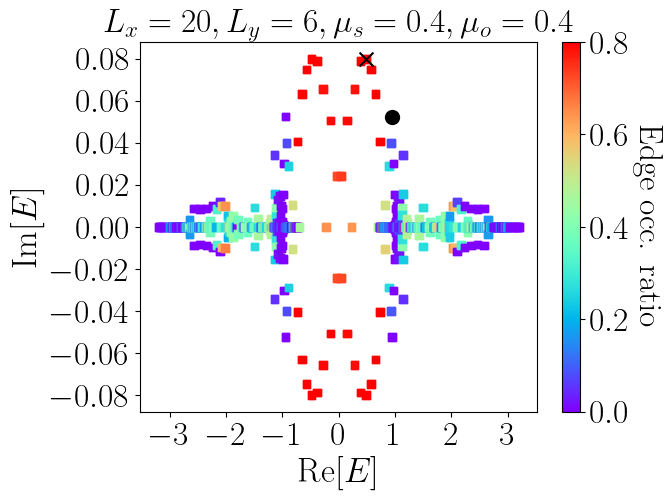

m = 1.0, gamma = 0.13333333333333333, imE_max_bulk = 0.05242690118419084, imE_max_topo = 0.07992563773030963, imE_diff = 0.027498736546118785
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


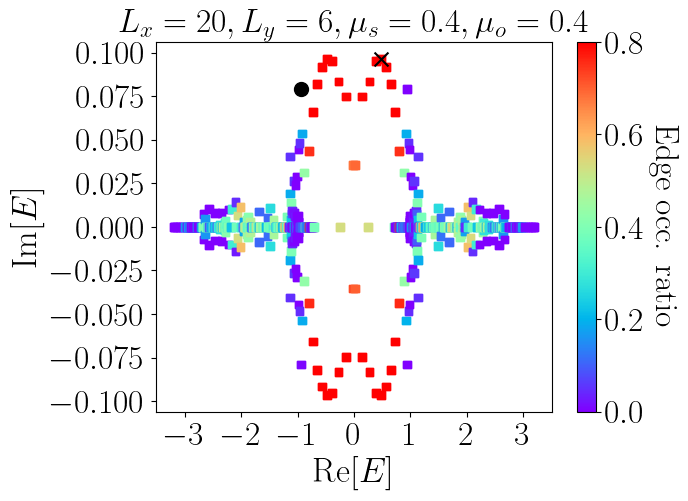

m = 1.0, gamma = 0.15555555555555556, imE_max_bulk = 0.07897060162187475, imE_max_topo = 0.09639228433637322, imE_diff = 0.017421682714498468
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


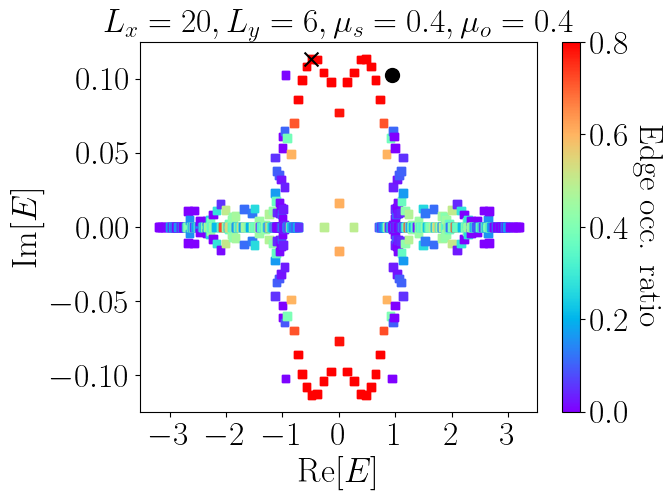

m = 1.0, gamma = 0.17777777777777778, imE_max_bulk = 0.10236405998487101, imE_max_topo = 0.1133508106693813, imE_diff = 0.010986750684510285
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


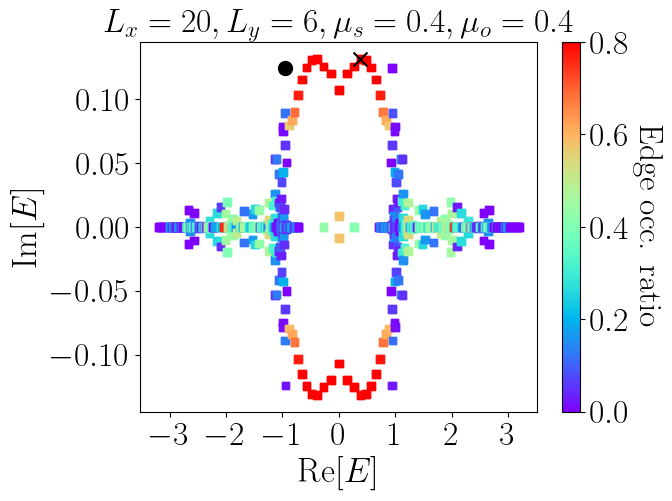

m = 1.0, gamma = 0.2, imE_max_bulk = 0.12422599007586205, imE_max_topo = 0.1315153861987581, imE_diff = 0.007289396122896058
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


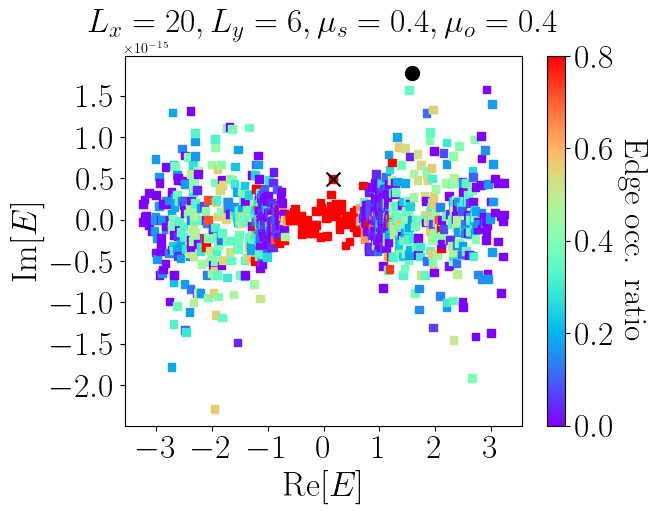

m = 1.0222222222222221, gamma = 0.0, imE_max_bulk = 1.7763568369308336e-15, imE_max_topo = 4.95021833321176e-16, imE_diff = -1.2813350036096576e-15
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


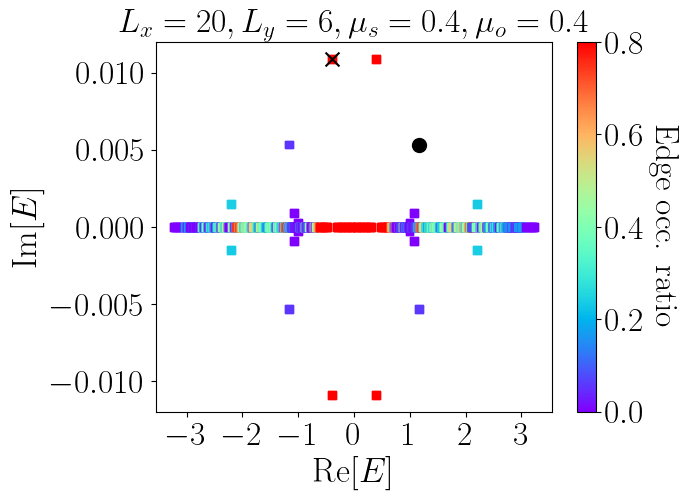

m = 1.0222222222222221, gamma = 0.022222222222222223, imE_max_bulk = 0.005336458504551611, imE_max_topo = 0.01089828694306446, imE_diff = 0.005561828438512849
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


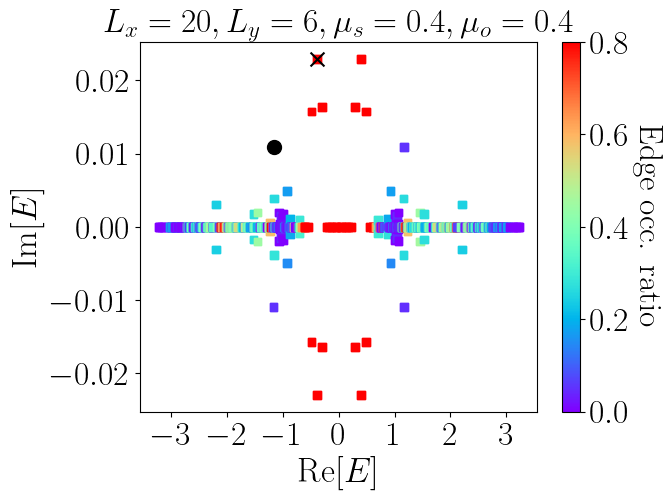

m = 1.0222222222222221, gamma = 0.044444444444444446, imE_max_bulk = 0.010927316413305455, imE_max_topo = 0.02295444680890677, imE_diff = 0.012027130395601316
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


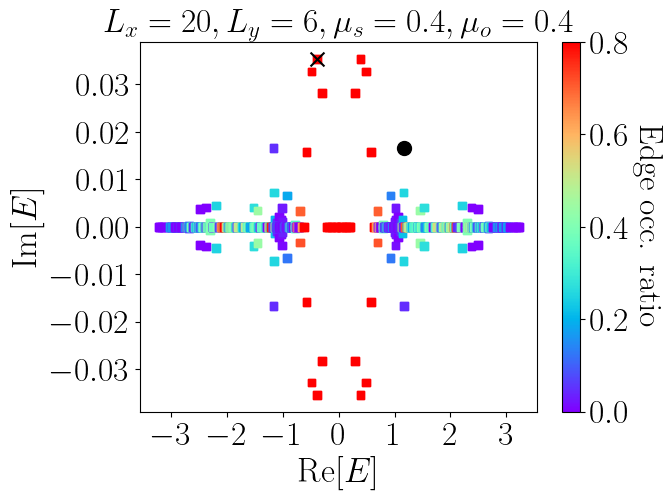

m = 1.0222222222222221, gamma = 0.06666666666666667, imE_max_bulk = 0.016674080554540113, imE_max_topo = 0.03539412510691358, imE_diff = 0.018720044552373468
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


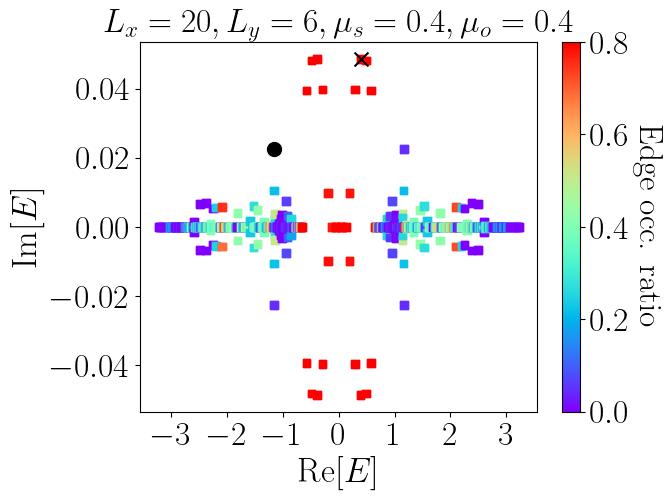

m = 1.0222222222222221, gamma = 0.08888888888888889, imE_max_bulk = 0.022529285289203026, imE_max_topo = 0.04857444298524087, imE_diff = 0.026045157696037845
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


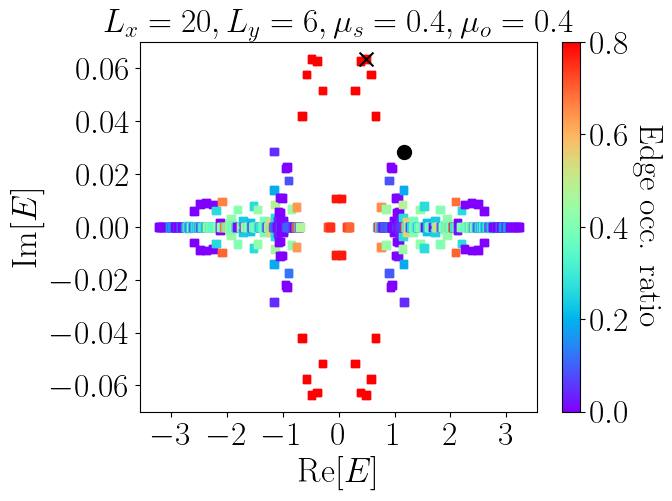

m = 1.0222222222222221, gamma = 0.11111111111111112, imE_max_bulk = 0.028484092871138494, imE_max_topo = 0.06359974184466757, imE_diff = 0.035115648973529076
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


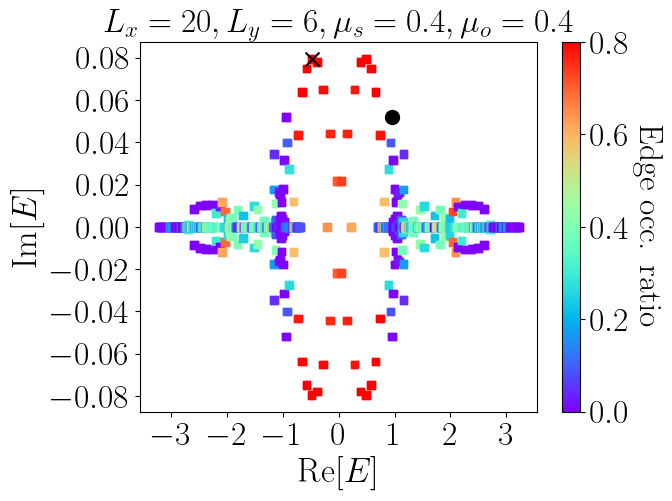

m = 1.0222222222222221, gamma = 0.13333333333333333, imE_max_bulk = 0.05188173134110102, imE_max_topo = 0.07944666669156808, imE_diff = 0.027564935350467057
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


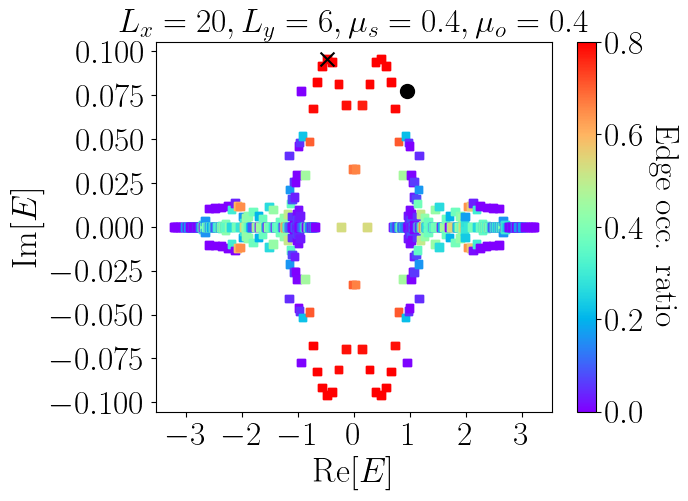

m = 1.0222222222222221, gamma = 0.15555555555555556, imE_max_bulk = 0.07741123848870383, imE_max_topo = 0.09578791809409466, imE_diff = 0.018376679605390828
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


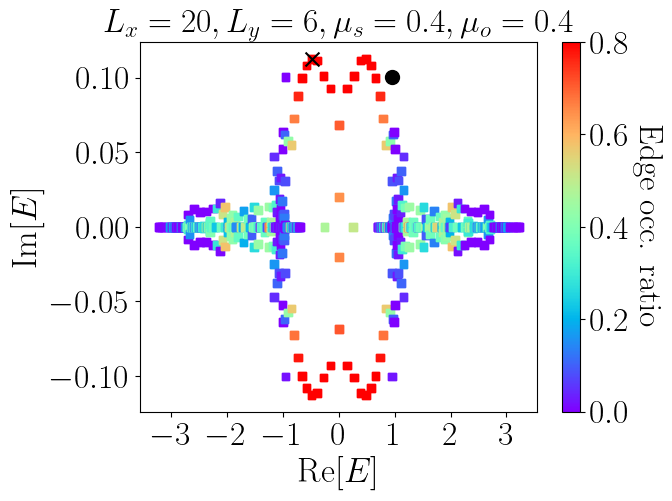

m = 1.0222222222222221, gamma = 0.17777777777777778, imE_max_bulk = 0.10041383724555576, imE_max_topo = 0.11266175113044326, imE_diff = 0.012247913884887496
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


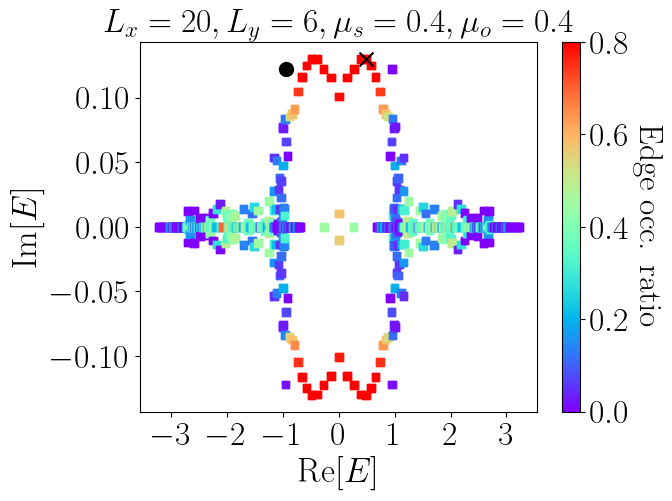

m = 1.0222222222222221, gamma = 0.2, imE_max_bulk = 0.12202358481359636, imE_max_topo = 0.13010048449309358, imE_diff = 0.008076899679497221
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


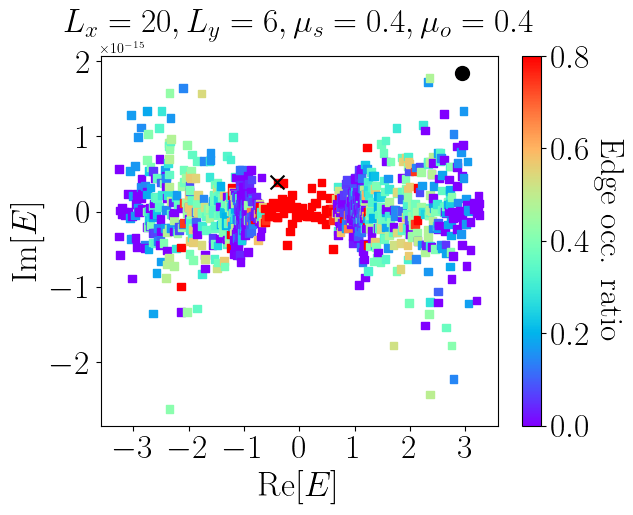

m = 1.0444444444444445, gamma = 0.0, imE_max_bulk = 1.8421766750022318e-15, imE_max_topo = 3.8857805861880523e-16, imE_diff = -1.4535986163834266e-15
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


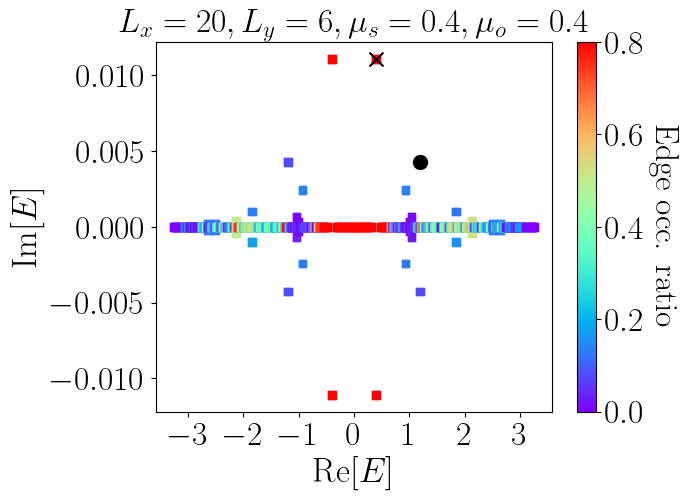

m = 1.0444444444444445, gamma = 0.022222222222222223, imE_max_bulk = 0.004280843780702854, imE_max_topo = 0.011095319723728384, imE_diff = 0.00681447594302553
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


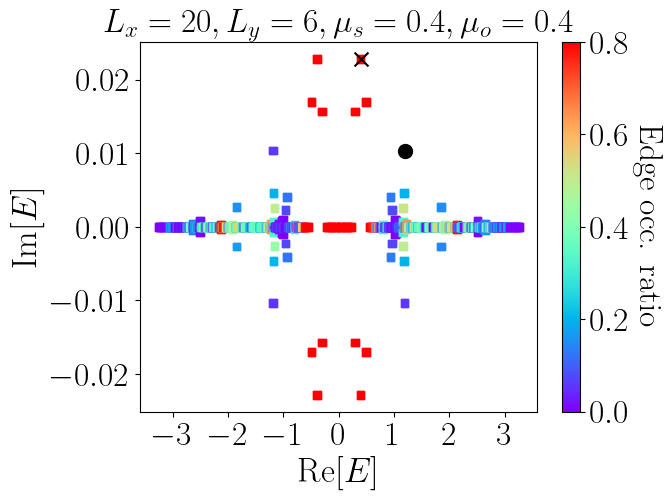

m = 1.0444444444444445, gamma = 0.044444444444444446, imE_max_bulk = 0.010356837737359728, imE_max_topo = 0.022816809758695492, imE_diff = 0.012459972021335764
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


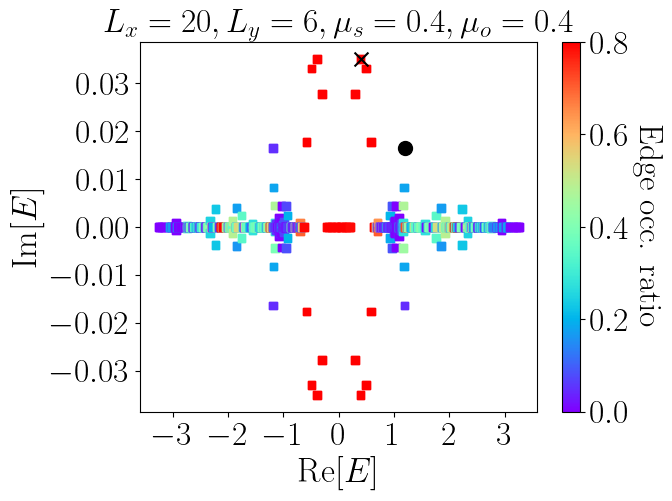

m = 1.0444444444444445, gamma = 0.06666666666666667, imE_max_bulk = 0.016404038769029308, imE_max_topo = 0.035030621572763196, imE_diff = 0.018626582803733888
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


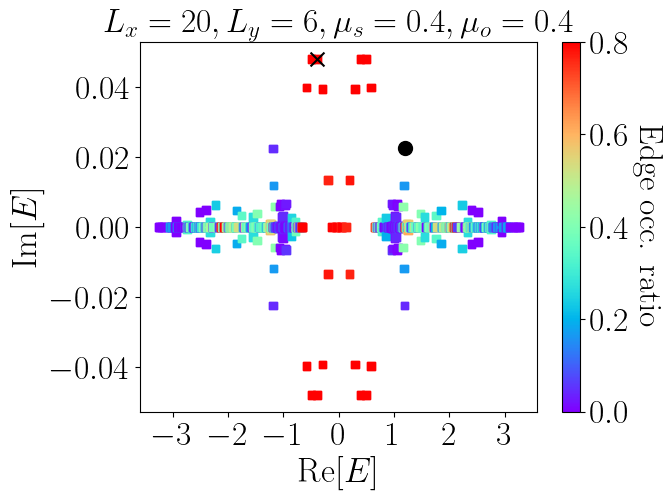

m = 1.0444444444444445, gamma = 0.08888888888888889, imE_max_bulk = 0.0224238525860406, imE_max_topo = 0.047995225734170505, imE_diff = 0.025571373148129906
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


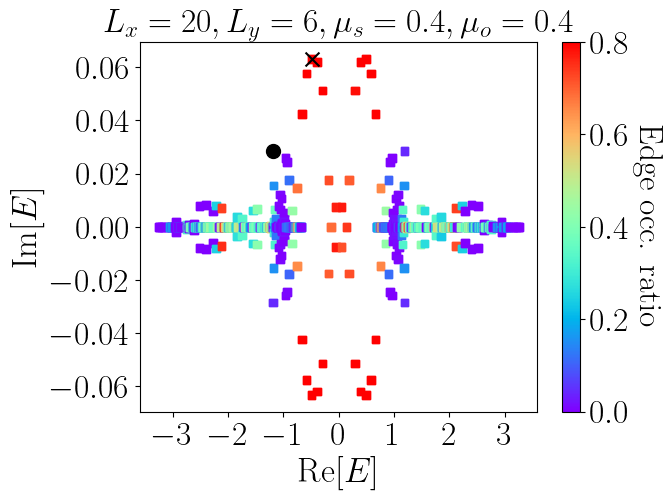

m = 1.0444444444444445, gamma = 0.11111111111111112, imE_max_bulk = 0.028482181787799554, imE_max_topo = 0.0631517314419724, imE_diff = 0.03466954965417285
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


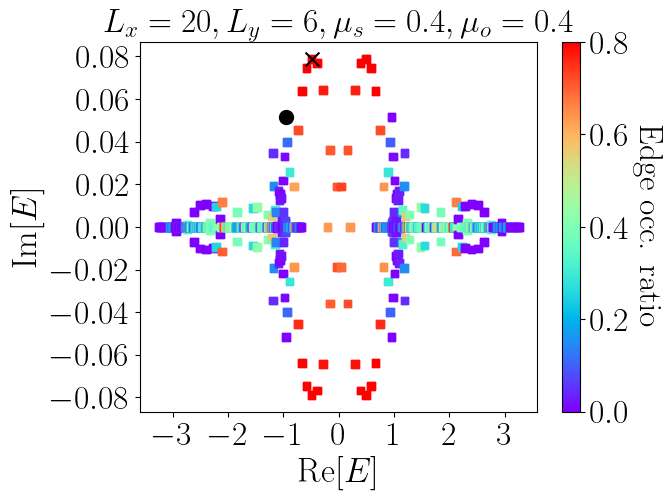

m = 1.0444444444444445, gamma = 0.13333333333333333, imE_max_bulk = 0.05153622356204845, imE_max_topo = 0.07879841961796112, imE_diff = 0.027262196055912673
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


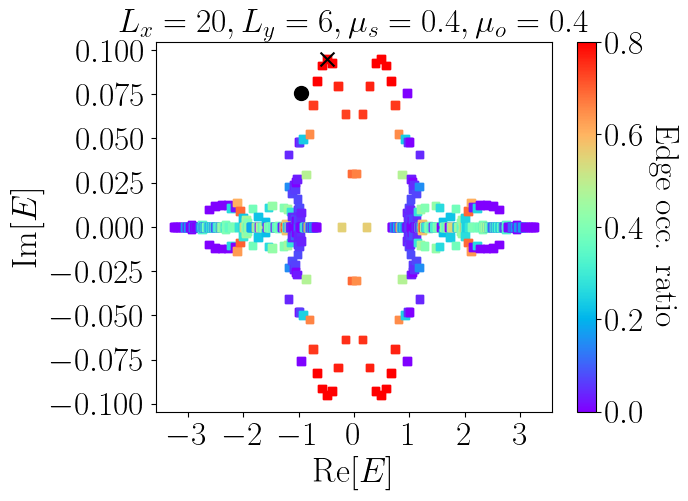

m = 1.0444444444444445, gamma = 0.15555555555555556, imE_max_bulk = 0.0758569362054141, imE_max_topo = 0.09499764602133287, imE_diff = 0.01914070981591877
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


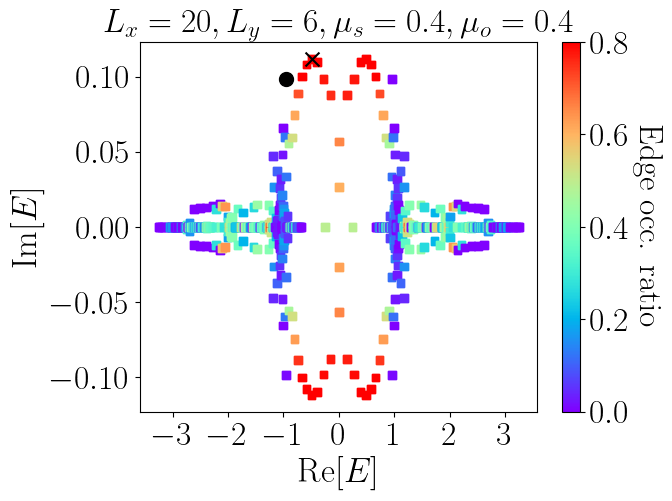

m = 1.0444444444444445, gamma = 0.17777777777777778, imE_max_bulk = 0.09841138821983988, imE_max_topo = 0.11177410084425567, imE_diff = 0.013362712624415782
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


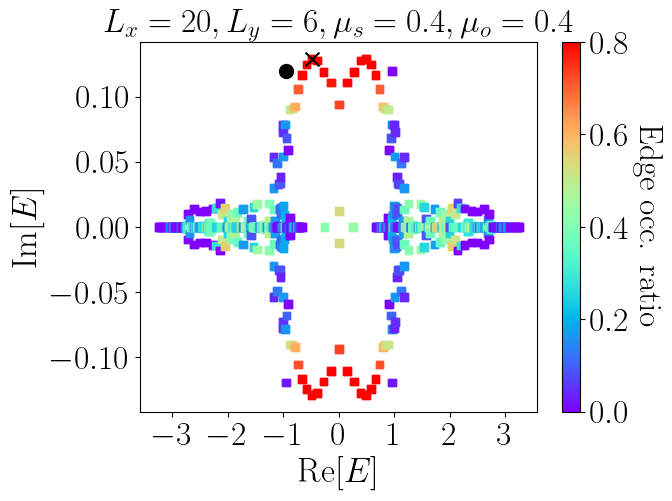

m = 1.0444444444444445, gamma = 0.2, imE_max_bulk = 0.11973905413866398, imE_max_topo = 0.12914582341974098, imE_diff = 0.009406769281077004
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


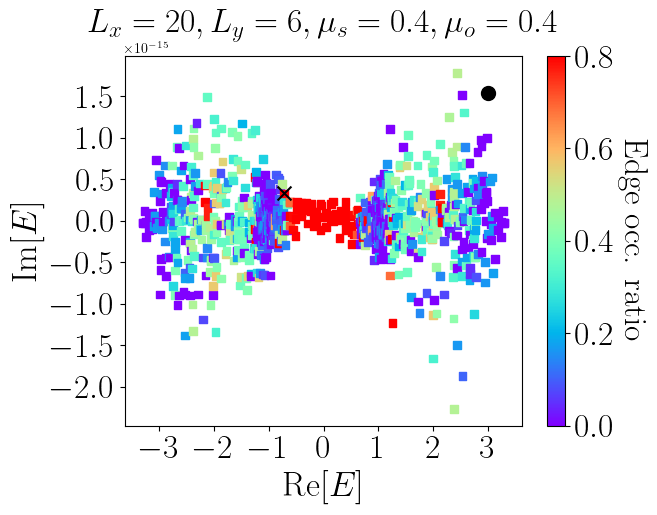

m = 1.0666666666666667, gamma = 0.0, imE_max_bulk = 1.5352298926432719e-15, imE_max_topo = 3.2817526624713323e-16, imE_diff = -1.2070546263961386e-15
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


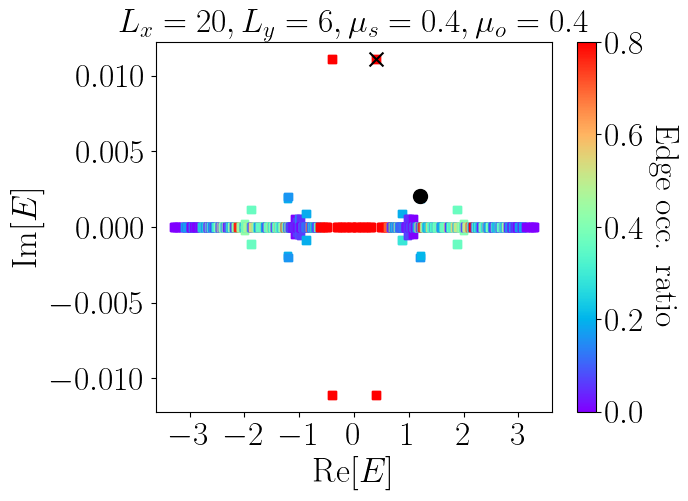

m = 1.0666666666666667, gamma = 0.022222222222222223, imE_max_bulk = 0.002018733657375718, imE_max_topo = 0.01110563138468548, imE_diff = 0.009086897727309761
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


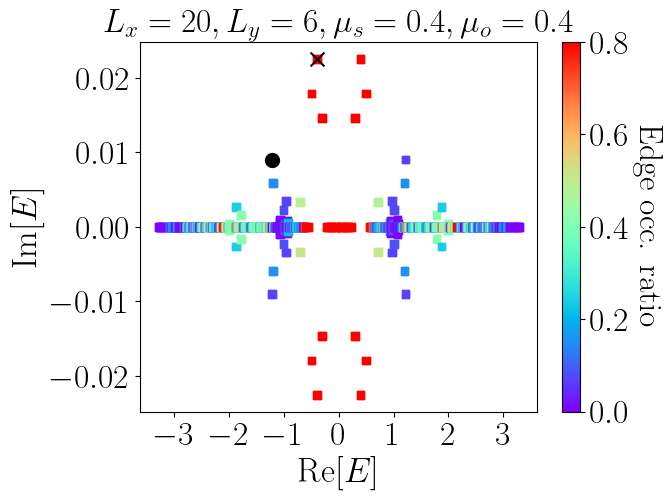

m = 1.0666666666666667, gamma = 0.044444444444444446, imE_max_bulk = 0.00904104455607857, imE_max_topo = 0.022548618081783732, imE_diff = 0.013507573525705162
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


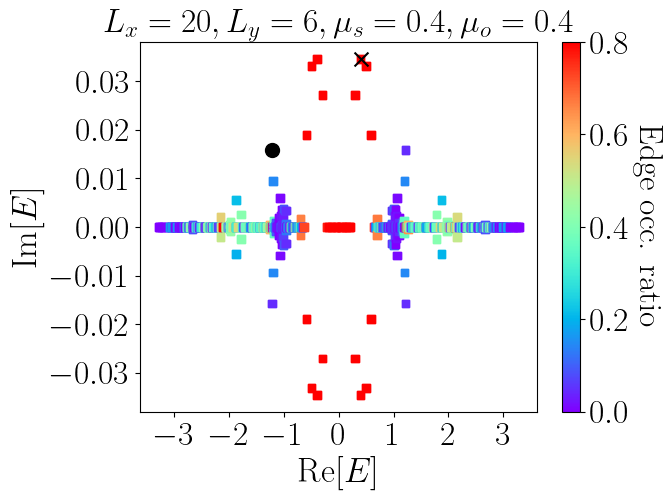

m = 1.0666666666666667, gamma = 0.06666666666666667, imE_max_bulk = 0.01575344139601237, imE_max_topo = 0.034536970075492966, imE_diff = 0.018783528679480598
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


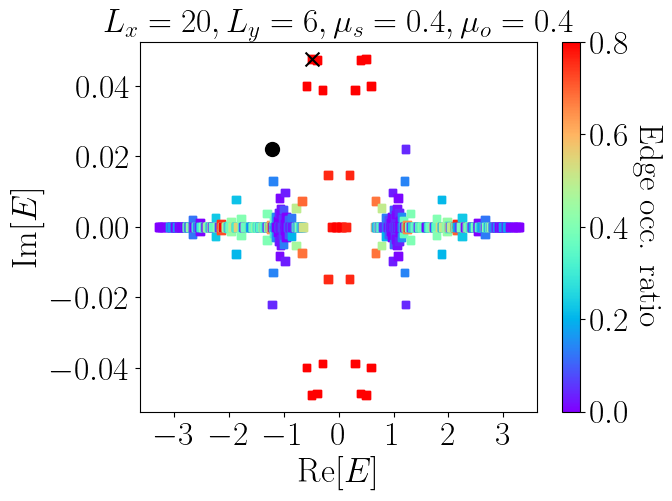

m = 1.0666666666666667, gamma = 0.08888888888888889, imE_max_bulk = 0.02203779520646737, imE_max_topo = 0.04766067714086082, imE_diff = 0.02562288193439345
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


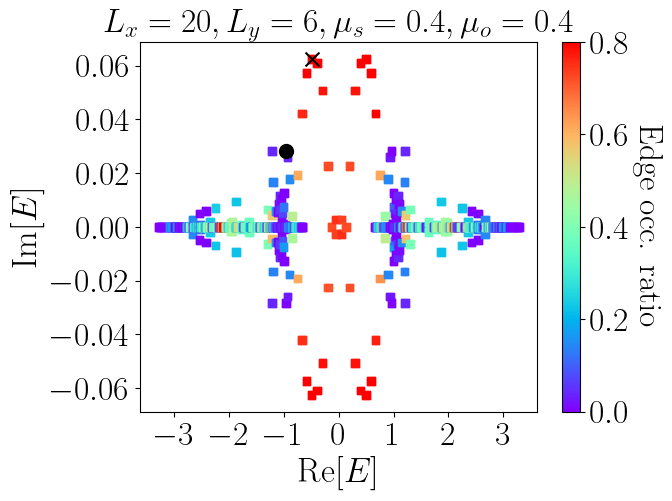

m = 1.0666666666666667, gamma = 0.11111111111111112, imE_max_bulk = 0.02830580373616726, imE_max_topo = 0.06253319750712658, imE_diff = 0.03422739377095932
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


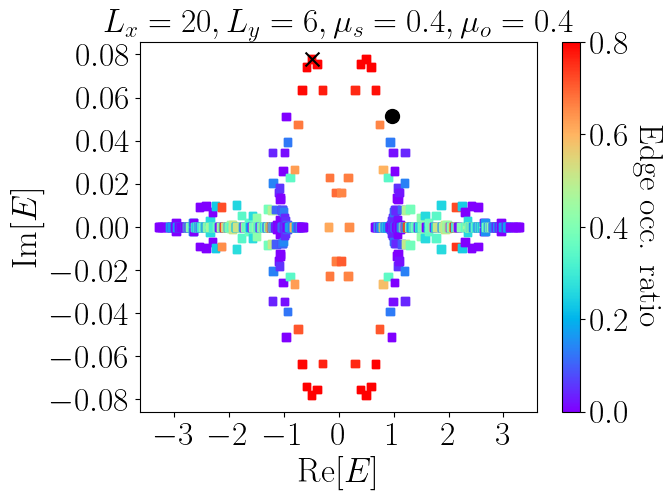

m = 1.0666666666666667, gamma = 0.13333333333333333, imE_max_bulk = 0.051219633208136, imE_max_topo = 0.07795972637191481, imE_diff = 0.02674009316377881
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


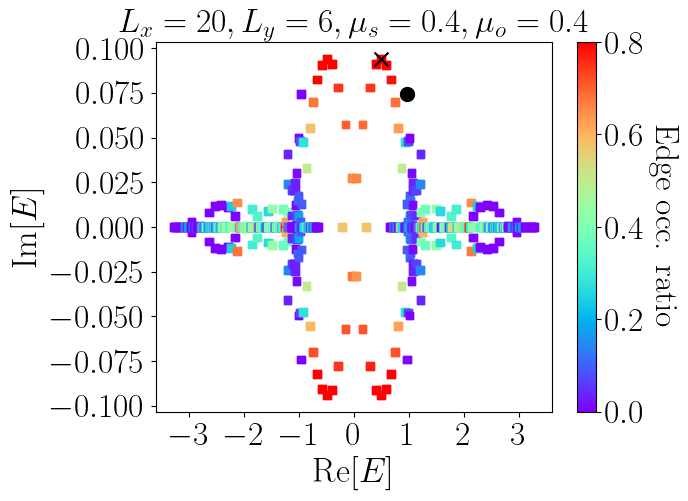

m = 1.0666666666666667, gamma = 0.15555555555555556, imE_max_bulk = 0.07429561559847069, imE_max_topo = 0.09399931028248783, imE_diff = 0.019703694684017142
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


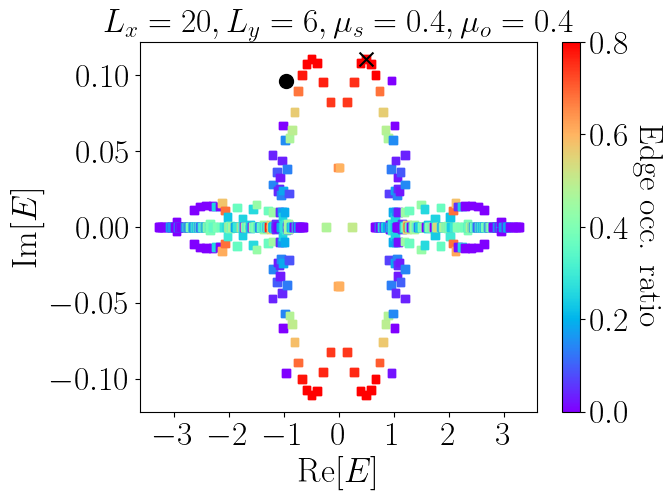

m = 1.0666666666666667, gamma = 0.17777777777777778, imE_max_bulk = 0.09637546075312398, imE_max_topo = 0.11066579513973313, imE_diff = 0.01429033438660915
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


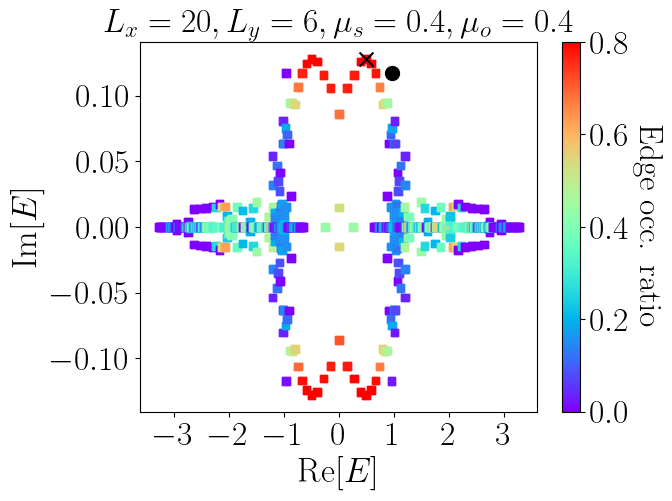

m = 1.0666666666666667, gamma = 0.2, imE_max_bulk = 0.11740419105063546, imE_max_topo = 0.12796462913853612, imE_diff = 0.010560438087900664
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


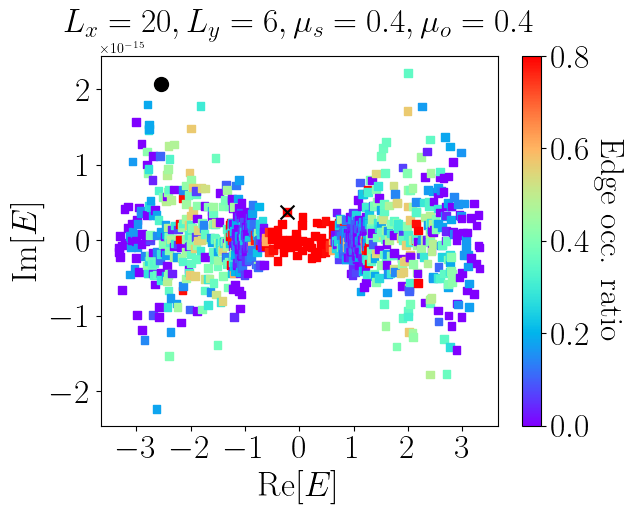

m = 1.0888888888888888, gamma = 0.0, imE_max_bulk = 2.0736972089543517e-15, imE_max_topo = 3.7242316631172666e-16, imE_diff = -1.701274042642625e-15
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


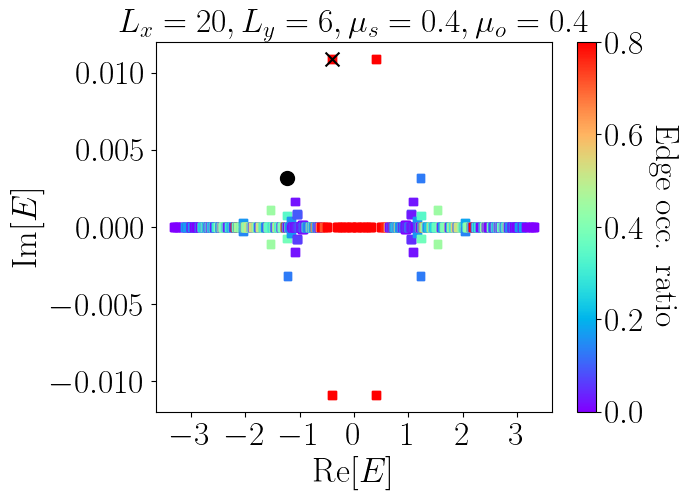

m = 1.0888888888888888, gamma = 0.022222222222222223, imE_max_bulk = 0.003188411180386287, imE_max_topo = 0.010903185077886662, imE_diff = 0.007714773897500375
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


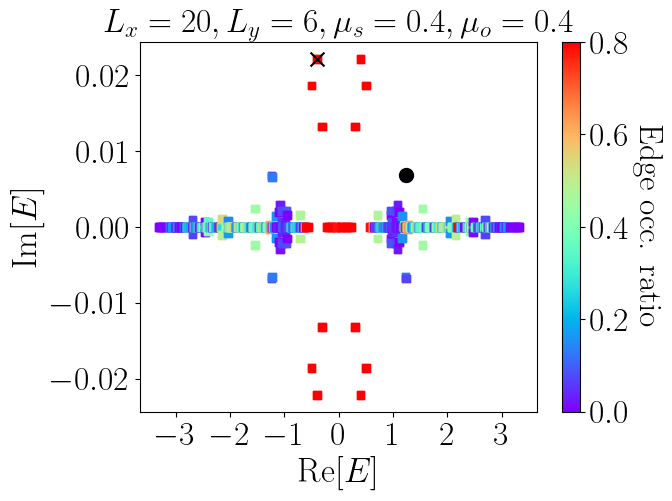

m = 1.0888888888888888, gamma = 0.044444444444444446, imE_max_bulk = 0.006792399902713519, imE_max_topo = 0.02212991684391432, imE_diff = 0.0153375169412008
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


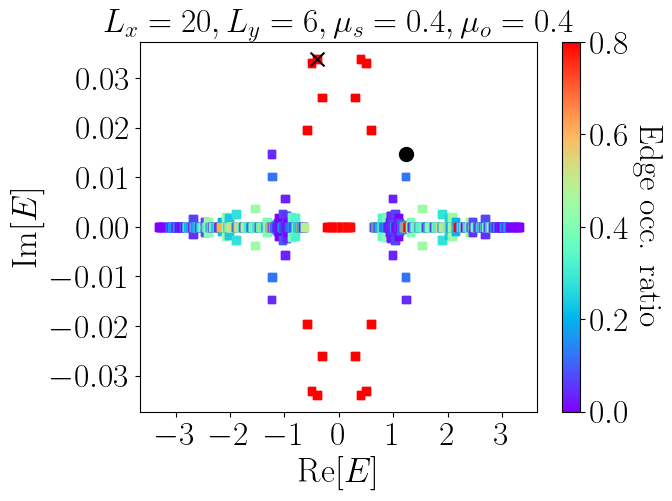

m = 1.0888888888888888, gamma = 0.06666666666666667, imE_max_bulk = 0.014665033762112454, imE_max_topo = 0.03389437092231303, imE_diff = 0.019229337160200578
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


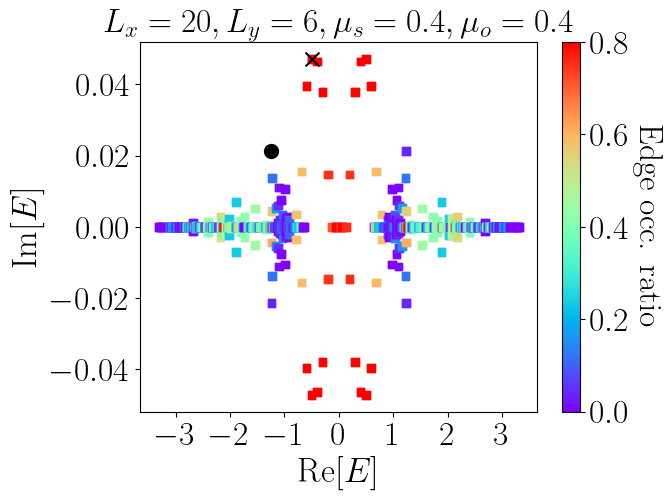

m = 1.0888888888888888, gamma = 0.08888888888888889, imE_max_bulk = 0.021338310828115988, imE_max_topo = 0.047166715106998845, imE_diff = 0.025828404278882857
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


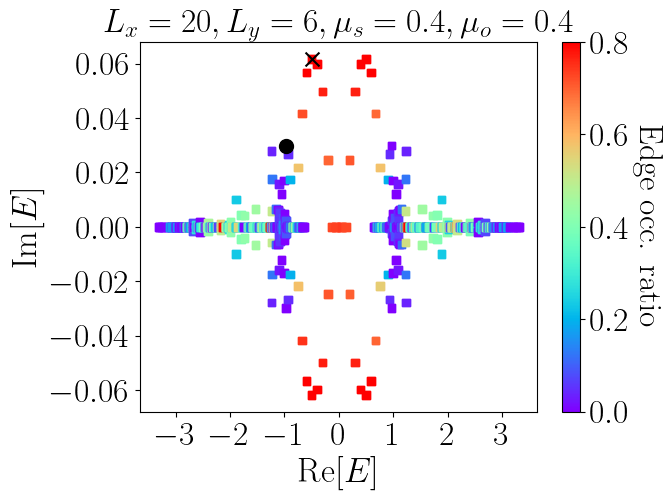

m = 1.0888888888888888, gamma = 0.11111111111111112, imE_max_bulk = 0.029840520032471292, imE_max_topo = 0.0617202623023952, imE_diff = 0.031879742269923905
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


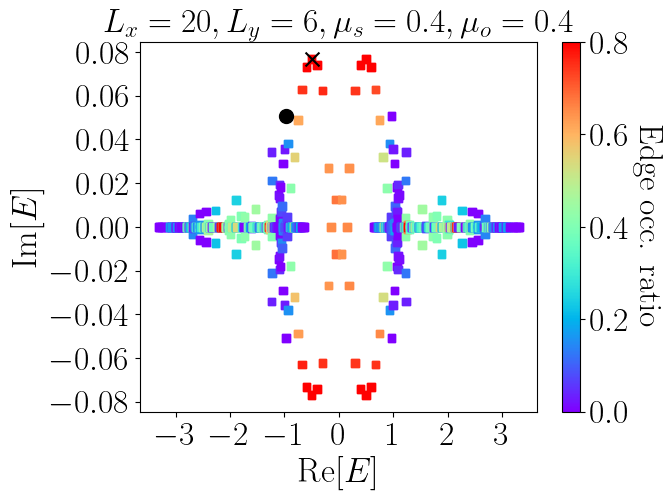

m = 1.0888888888888888, gamma = 0.13333333333333333, imE_max_bulk = 0.05073810649838439, imE_max_topo = 0.07690444547884814, imE_diff = 0.026166338980463756
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


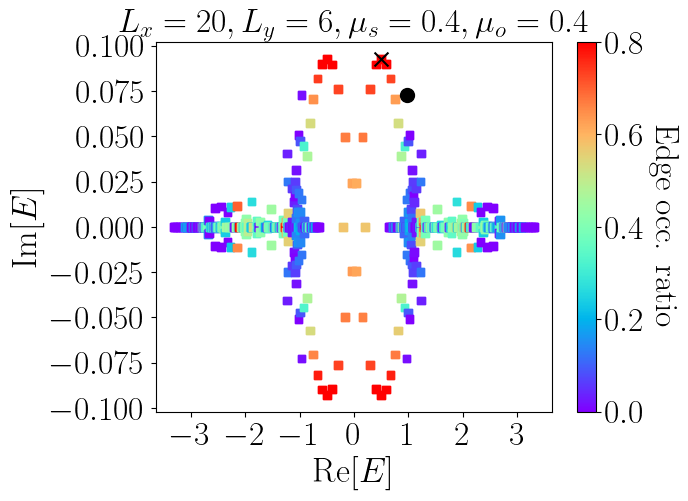

m = 1.0888888888888888, gamma = 0.15555555555555556, imE_max_bulk = 0.07273568036983531, imE_max_topo = 0.0927662895770889, imE_diff = 0.020030609207253594
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


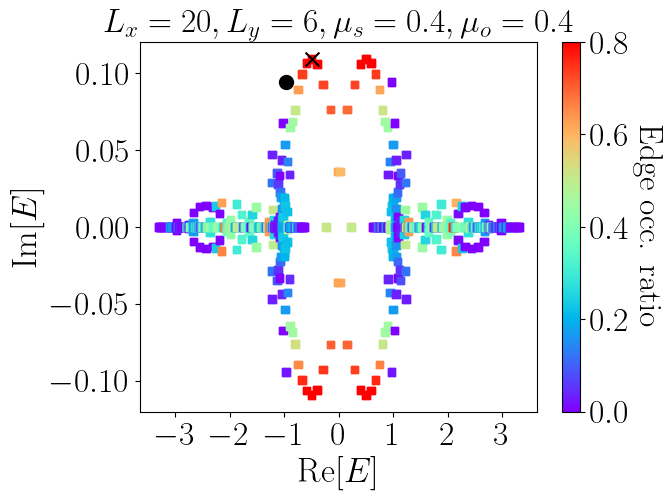

m = 1.0888888888888888, gamma = 0.17777777777777778, imE_max_bulk = 0.09434090621581591, imE_max_topo = 0.10931063812326347, imE_diff = 0.014969731907447562
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


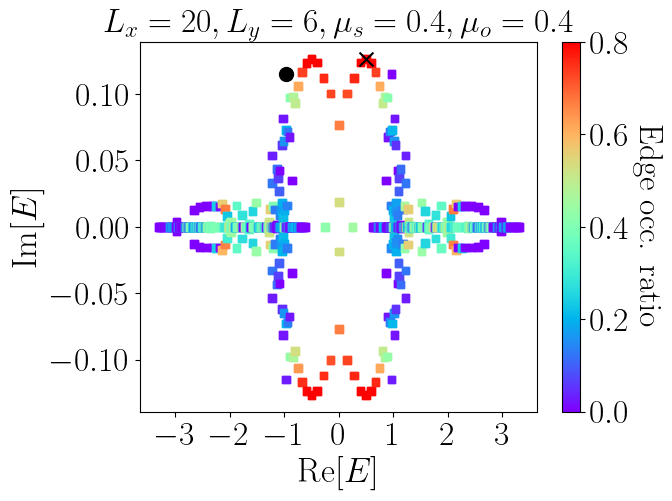

m = 1.0888888888888888, gamma = 0.2, imE_max_bulk = 0.11505096663926945, imE_max_topo = 0.12653199406954801, imE_diff = 0.011481027430278568
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


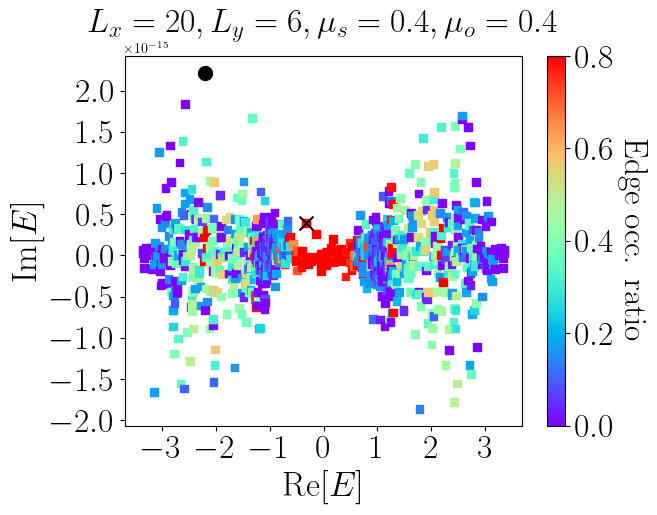

m = 1.1111111111111112, gamma = 0.0, imE_max_bulk = 2.214499046599403e-15, imE_max_topo = 3.964385243693247e-16, imE_diff = -1.8180605222300783e-15
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


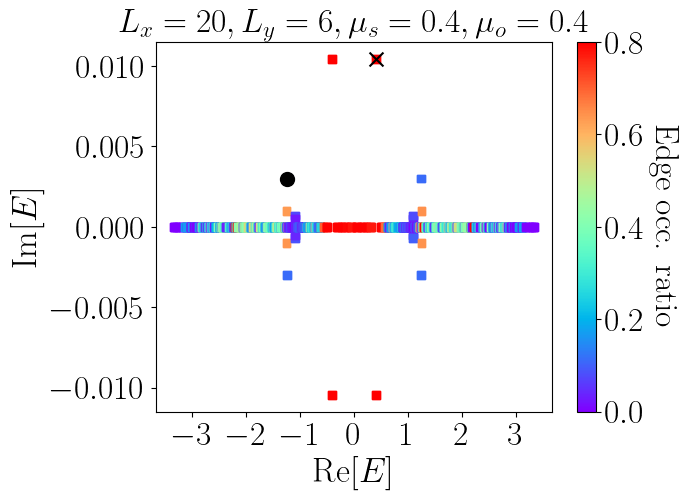

m = 1.1111111111111112, gamma = 0.022222222222222223, imE_max_bulk = 0.0030006532486758853, imE_max_topo = 0.010446083540175517, imE_diff = 0.007445430291499632
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


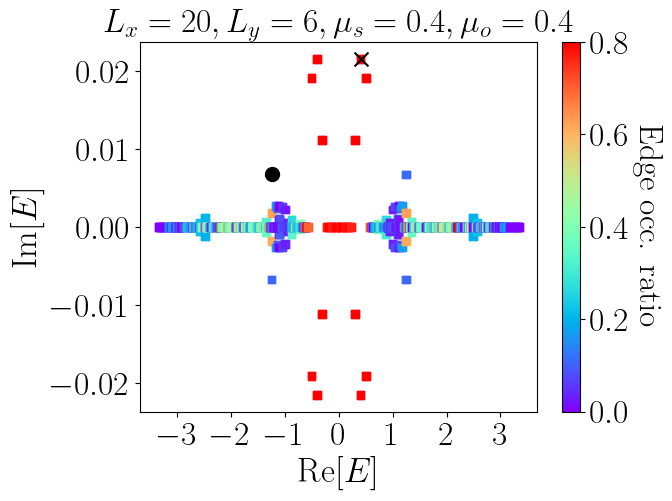

m = 1.1111111111111112, gamma = 0.044444444444444446, imE_max_bulk = 0.0067217302092962864, imE_max_topo = 0.021535358433859113, imE_diff = 0.014813628224562825
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


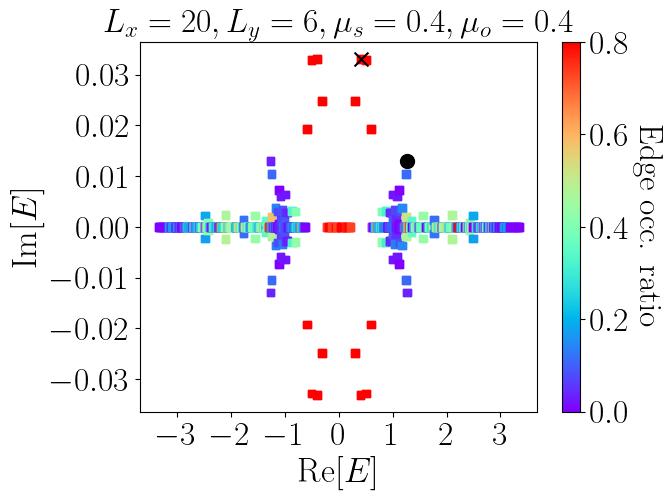

m = 1.1111111111111112, gamma = 0.06666666666666667, imE_max_bulk = 0.012914117699547867, imE_max_topo = 0.03308000183543122, imE_diff = 0.020165884135883355
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


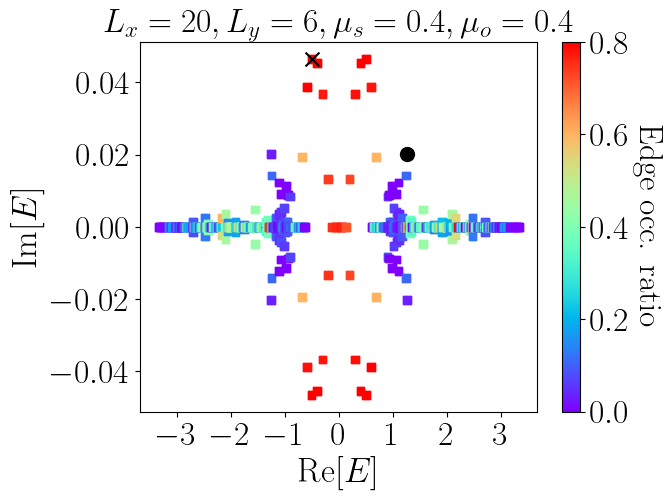

m = 1.1111111111111112, gamma = 0.08888888888888889, imE_max_bulk = 0.02021933838027349, imE_max_topo = 0.0464739422000653, imE_diff = 0.026254603819791812
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


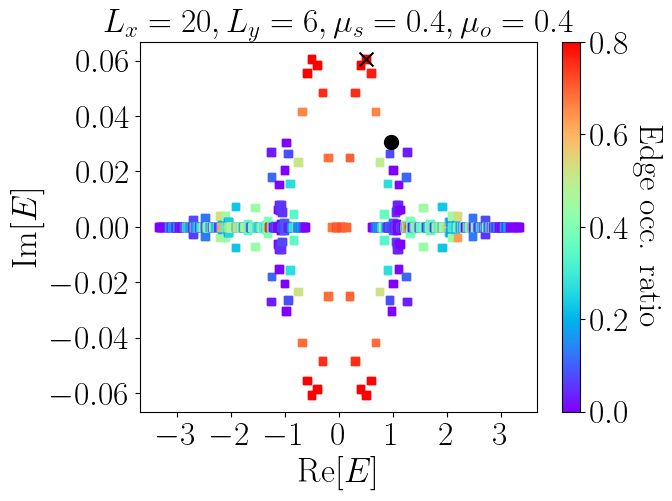

m = 1.1111111111111112, gamma = 0.11111111111111112, imE_max_bulk = 0.030481456128078503, imE_max_topo = 0.06068286541621964, imE_diff = 0.030201409288141134
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


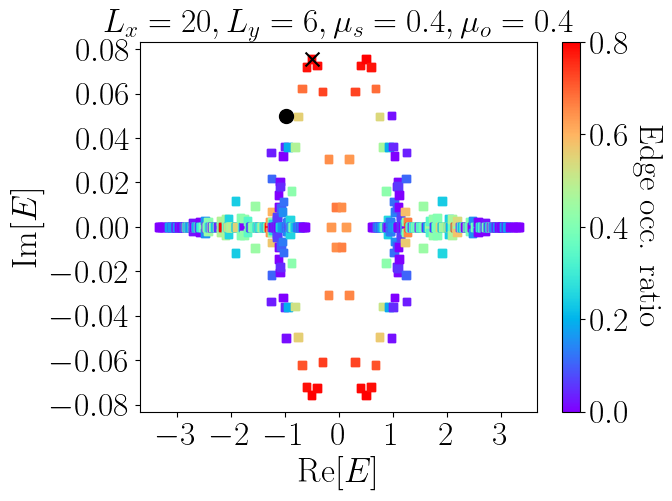

m = 1.1111111111111112, gamma = 0.13333333333333333, imE_max_bulk = 0.05004680594467383, imE_max_topo = 0.07560043330313758, imE_diff = 0.025553627358463747
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


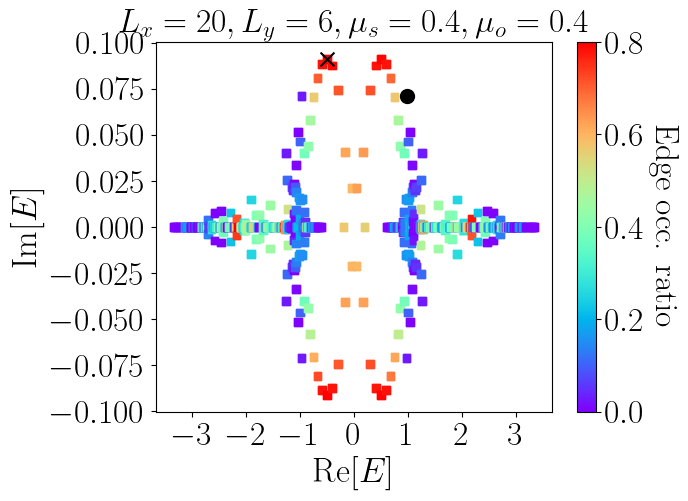

m = 1.1111111111111112, gamma = 0.15555555555555556, imE_max_bulk = 0.071202743712234, imE_max_topo = 0.09126610079111724, imE_diff = 0.020063357078883237
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


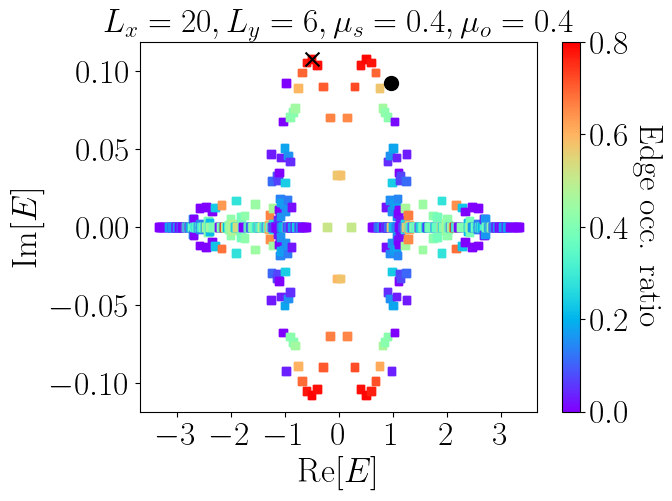

m = 1.1111111111111112, gamma = 0.17777777777777778, imE_max_bulk = 0.09232881835805432, imE_max_topo = 0.10767790822045163, imE_diff = 0.015349089862397317
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


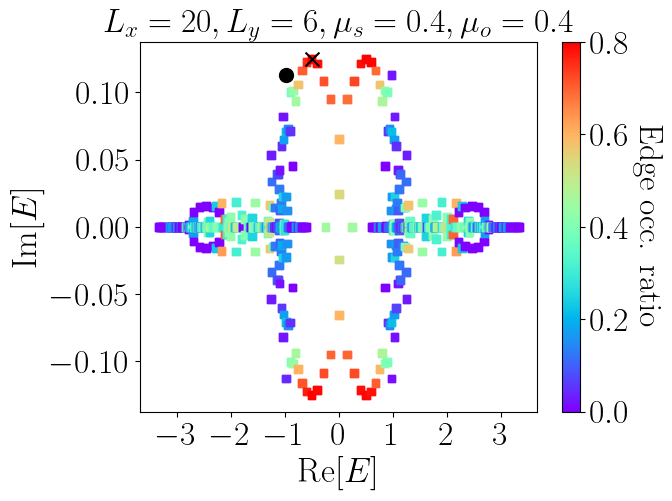

m = 1.1111111111111112, gamma = 0.2, imE_max_bulk = 0.11268744406109645, imE_max_topo = 0.12481947481121956, imE_diff = 0.012132030750123118
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


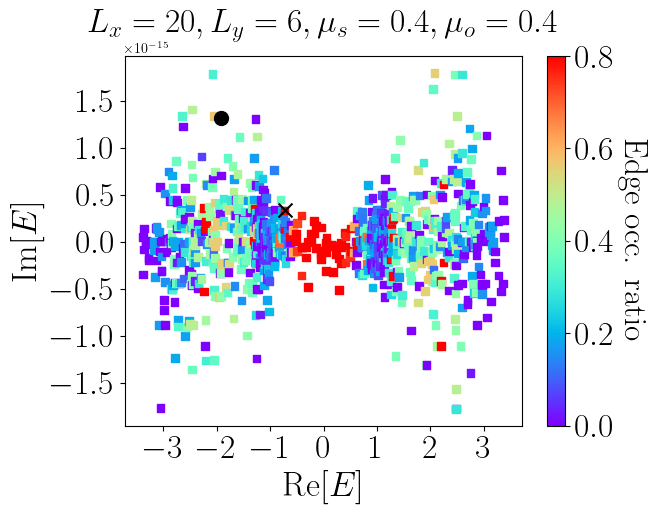

m = 1.1333333333333333, gamma = 0.0, imE_max_bulk = 1.31689757528937e-15, imE_max_topo = 3.330889000510774e-16, imE_diff = -9.838086752382925e-16
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


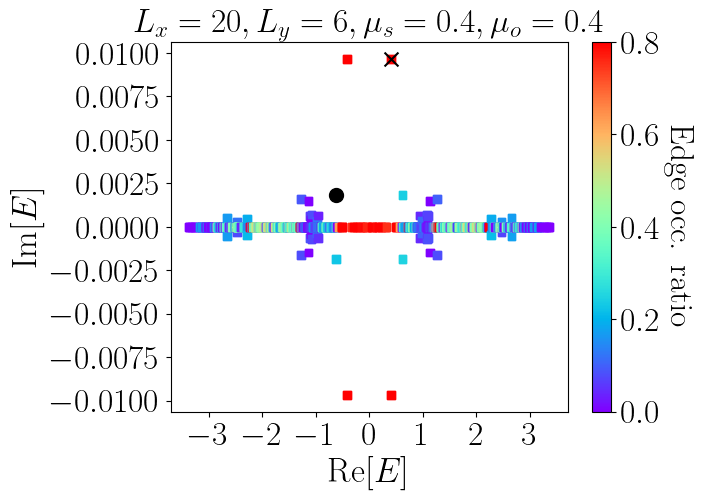

m = 1.1333333333333333, gamma = 0.022222222222222223, imE_max_bulk = 0.0018316480353357046, imE_max_topo = 0.009664551234102647, imE_diff = 0.007832903198766943
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


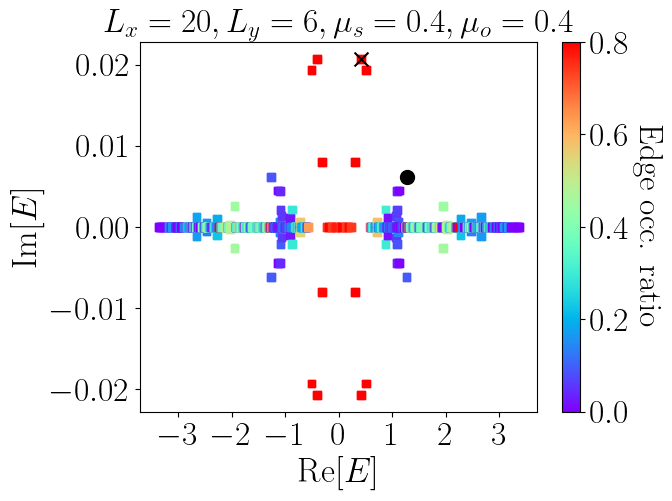

m = 1.1333333333333333, gamma = 0.044444444444444446, imE_max_bulk = 0.006178271850106855, imE_max_topo = 0.020731816005543767, imE_diff = 0.014553544155436911
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


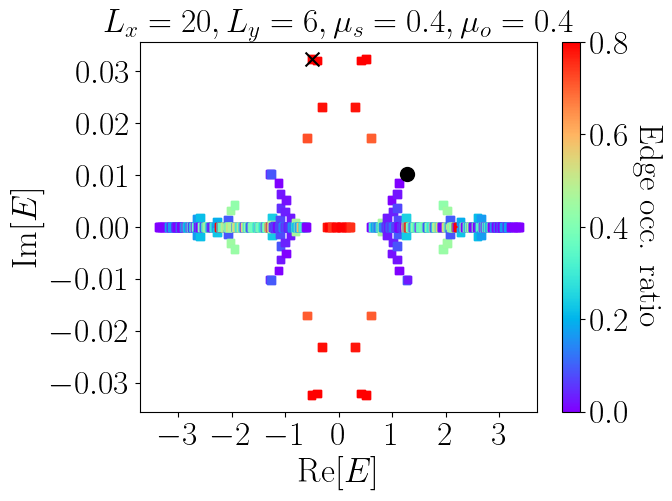

m = 1.1333333333333333, gamma = 0.06666666666666667, imE_max_bulk = 0.010189813078962787, imE_max_topo = 0.03236092030018592, imE_diff = 0.022171107221223132
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


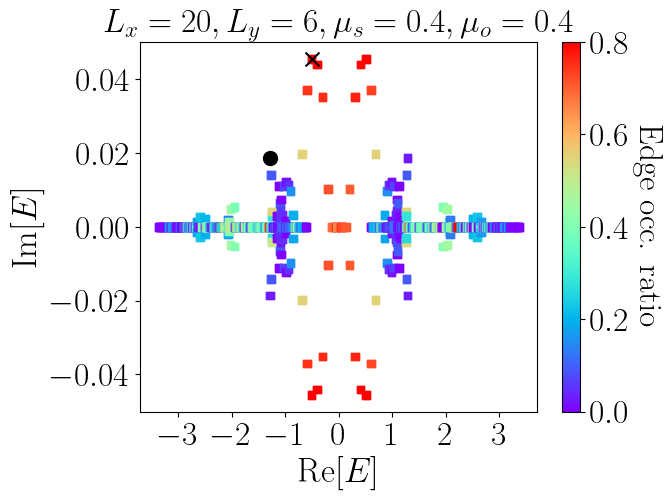

m = 1.1333333333333333, gamma = 0.08888888888888889, imE_max_bulk = 0.01859926392054015, imE_max_topo = 0.04554859976438348, imE_diff = 0.026949335843843333
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


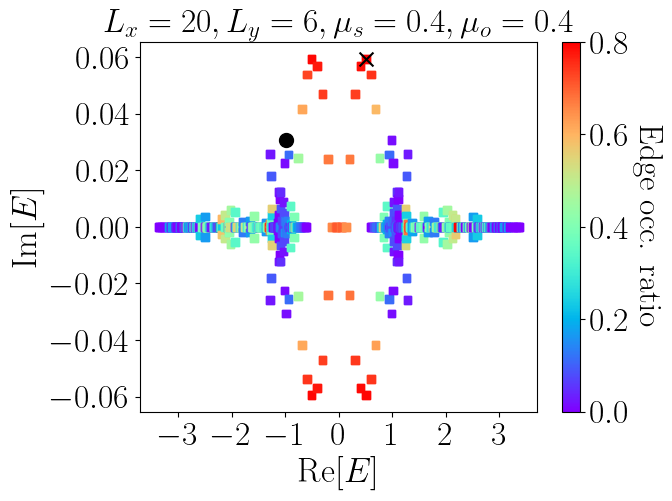

m = 1.1333333333333333, gamma = 0.11111111111111112, imE_max_bulk = 0.030673992504520912, imE_max_topo = 0.059382823346885535, imE_diff = 0.028708830842364624
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


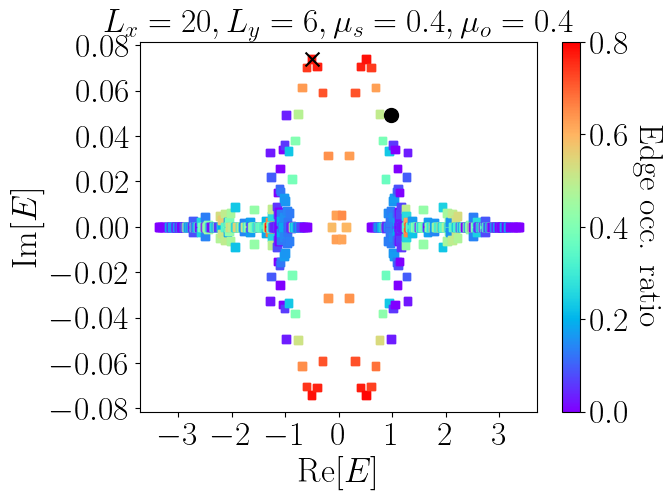

m = 1.1333333333333333, gamma = 0.13333333333333333, imE_max_bulk = 0.049296280307587106, imE_max_topo = 0.07400759391744577, imE_diff = 0.024711313609858662
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


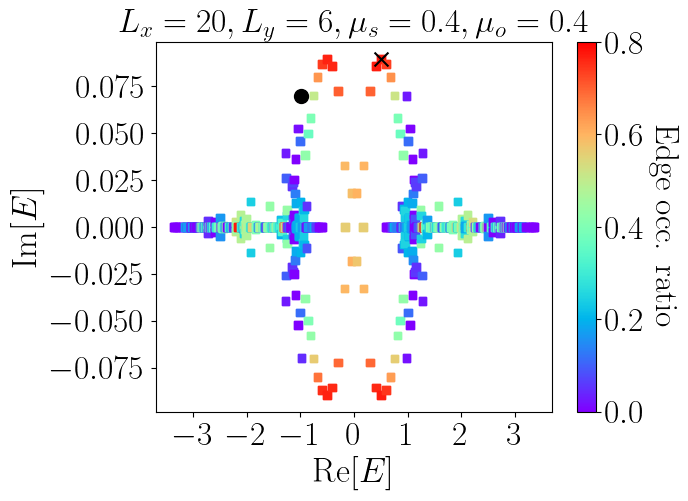

m = 1.1333333333333333, gamma = 0.15555555555555556, imE_max_bulk = 0.06970593623407131, imE_max_topo = 0.08945982696927303, imE_diff = 0.019753890735201715
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


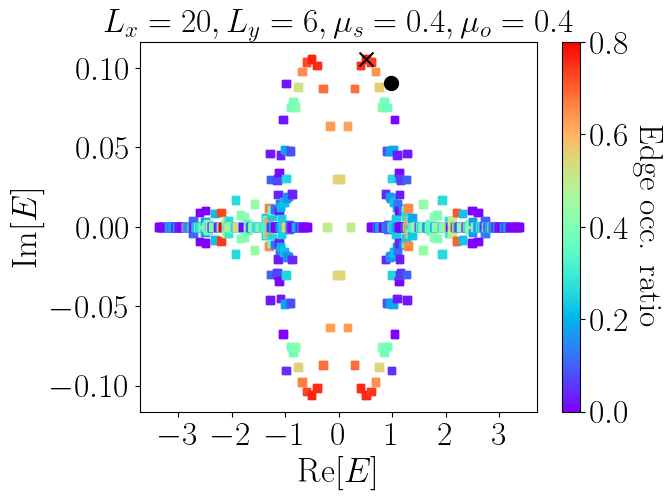

m = 1.1333333333333333, gamma = 0.17777777777777778, imE_max_bulk = 0.09031743678249335, imE_max_topo = 0.10573161633441658, imE_diff = 0.01541417955192323
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


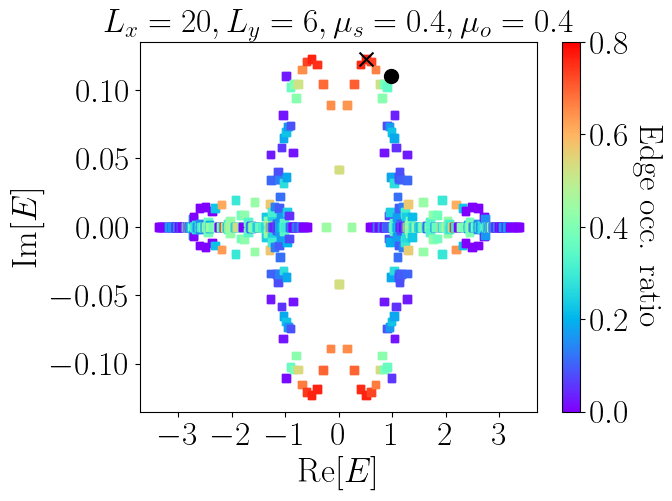

m = 1.1333333333333333, gamma = 0.2, imE_max_bulk = 0.11029059974667961, imE_max_topo = 0.12279522408816947, imE_diff = 0.012504624341489856
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


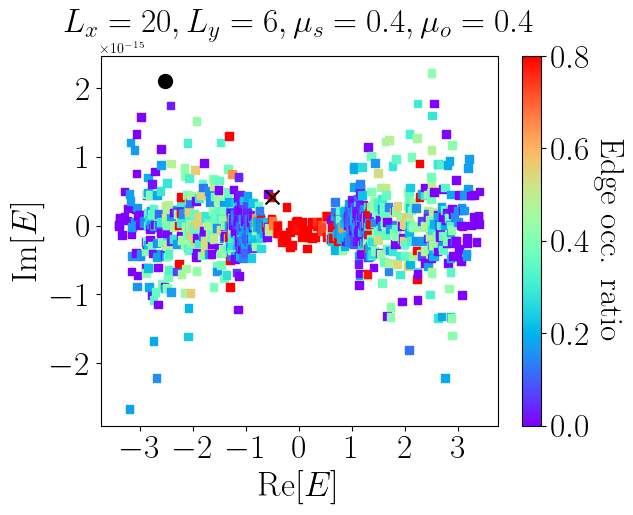

m = 1.1555555555555554, gamma = 0.0, imE_max_bulk = 2.104489057756842e-15, imE_max_topo = 4.137426266814744e-16, imE_diff = -1.6907464310753675e-15
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


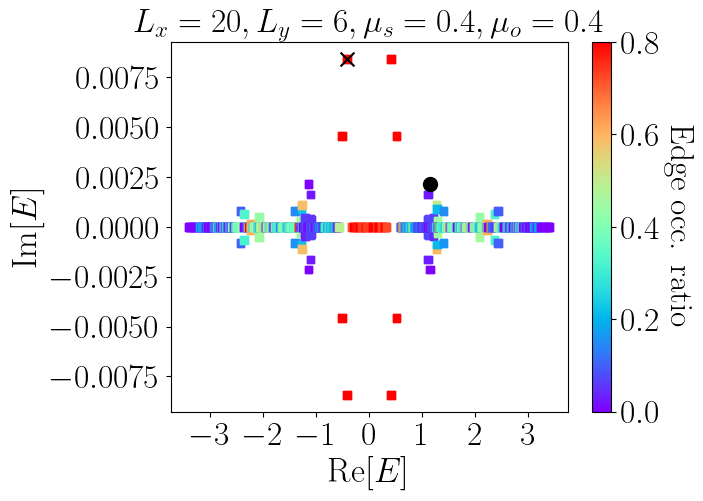

m = 1.1555555555555554, gamma = 0.022222222222222223, imE_max_bulk = 0.00213547358580164, imE_max_topo = 0.008428041200019765, imE_diff = 0.006292567614218125
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


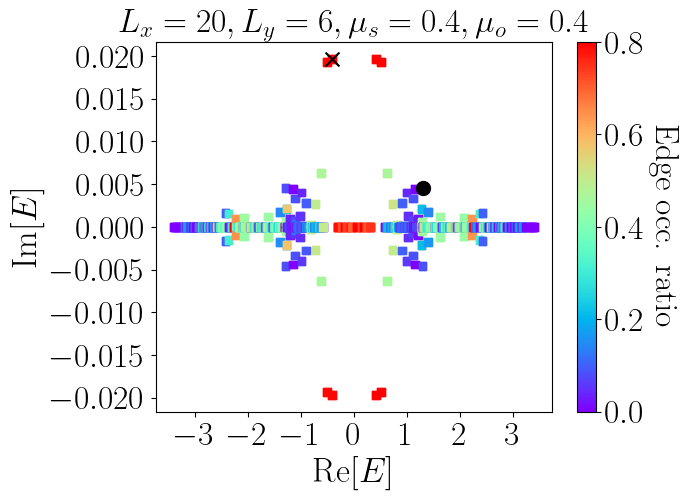

m = 1.1555555555555554, gamma = 0.044444444444444446, imE_max_bulk = 0.004562287184598752, imE_max_topo = 0.01967397851432577, imE_diff = 0.01511169132972702
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


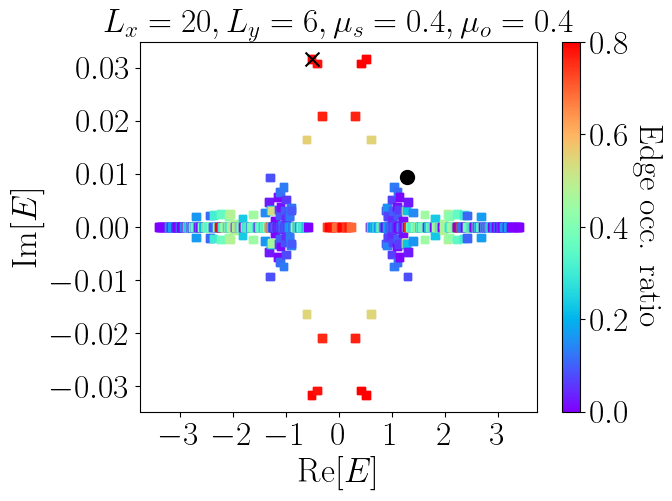

m = 1.1555555555555554, gamma = 0.06666666666666667, imE_max_bulk = 0.009316059059447273, imE_max_topo = 0.03165943810663162, imE_diff = 0.022343379047184343
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


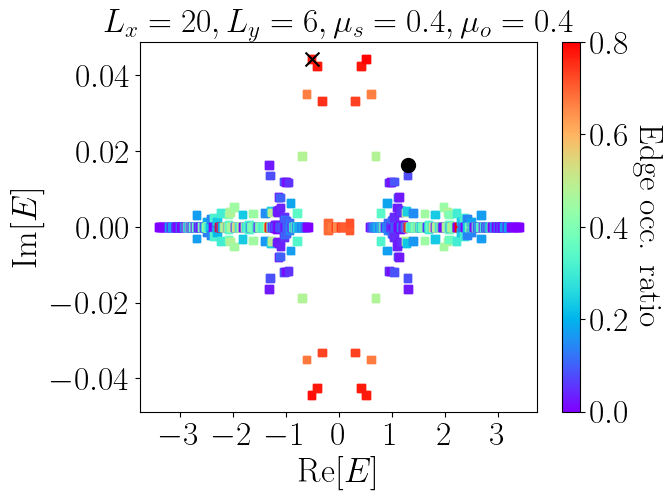

m = 1.1555555555555554, gamma = 0.08888888888888889, imE_max_bulk = 0.016319698338272737, imE_max_topo = 0.044344400217493155, imE_diff = 0.028024701879220418
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


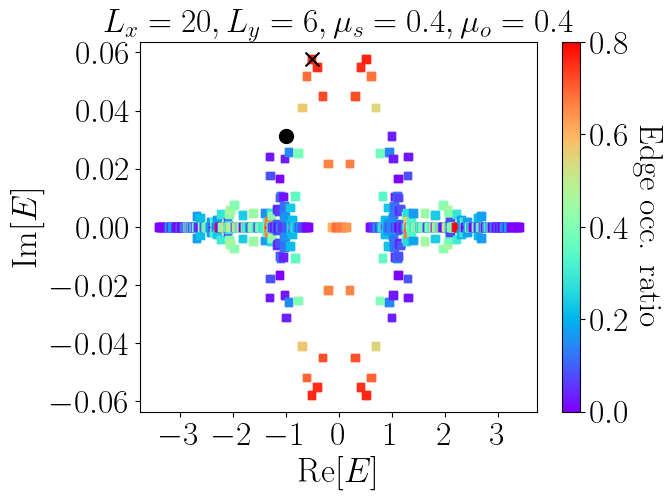

m = 1.1555555555555554, gamma = 0.11111111111111112, imE_max_bulk = 0.031149070576151572, imE_max_topo = 0.05777025279139373, imE_diff = 0.026621182215242158
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


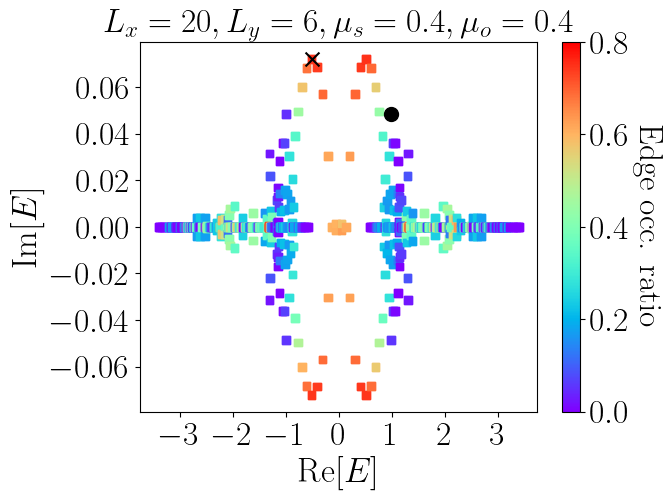

m = 1.1555555555555554, gamma = 0.13333333333333333, imE_max_bulk = 0.04854387313653207, imE_max_topo = 0.07207661316723352, imE_diff = 0.023532740030701445
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


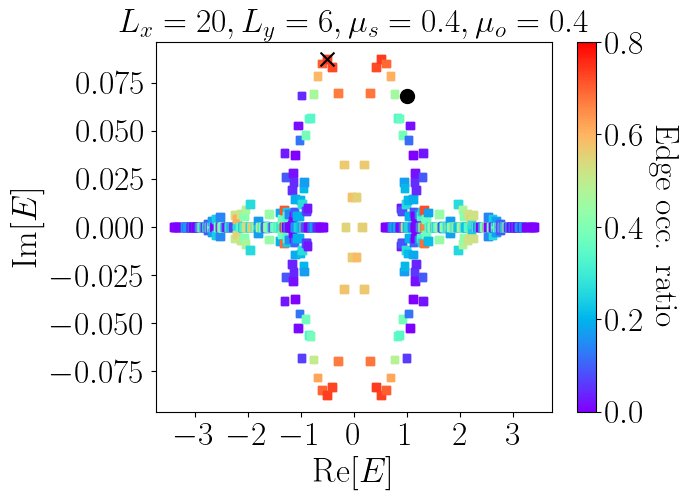

m = 1.1555555555555554, gamma = 0.15555555555555556, imE_max_bulk = 0.06820021131756275, imE_max_topo = 0.08730163722317401, imE_diff = 0.019101425905611258
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


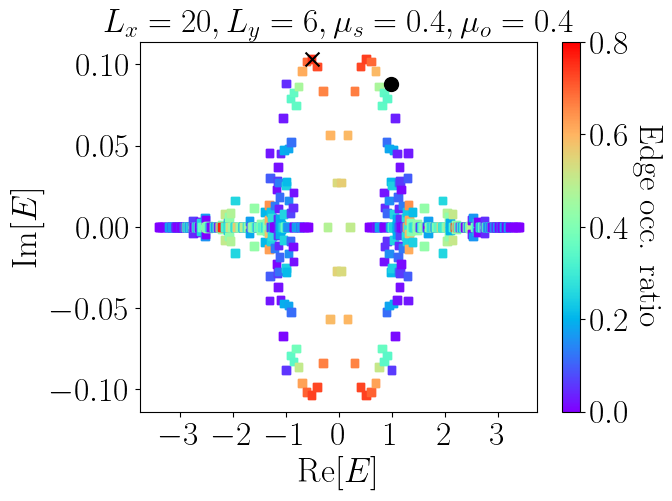

m = 1.1555555555555554, gamma = 0.17777777777777778, imE_max_bulk = 0.08825154120659105, imE_max_topo = 0.10343124762784729, imE_diff = 0.01517970642125624
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


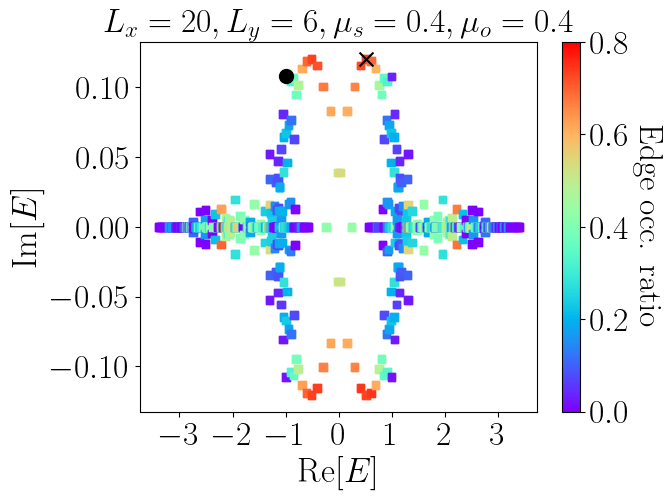

m = 1.1555555555555554, gamma = 0.2, imE_max_bulk = 0.10782188194198683, imE_max_topo = 0.12042385116267285, imE_diff = 0.012601969220686016
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


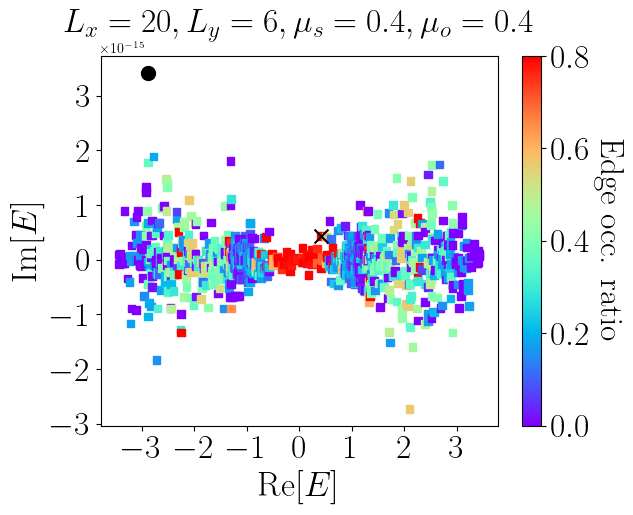

m = 1.1777777777777778, gamma = 0.0, imE_max_bulk = 3.4136710320223454e-15, imE_max_topo = 4.3630986837715407e-16, imE_diff = -2.9773611636451915e-15
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


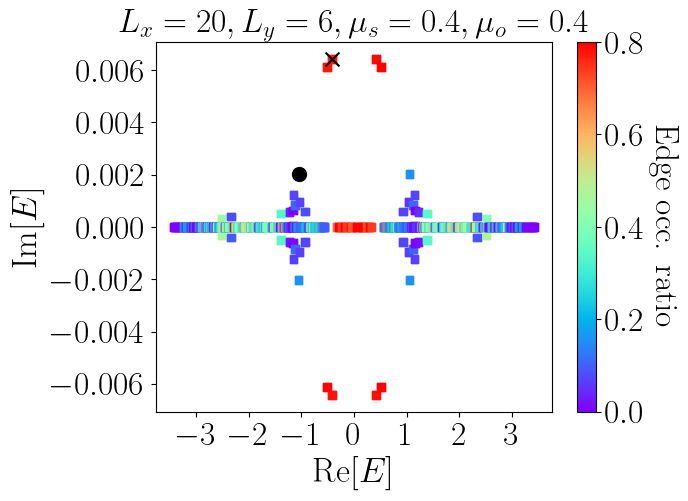

m = 1.1777777777777778, gamma = 0.022222222222222223, imE_max_bulk = 0.002020991464162106, imE_max_topo = 0.006422517791580179, imE_diff = 0.004401526327418073
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


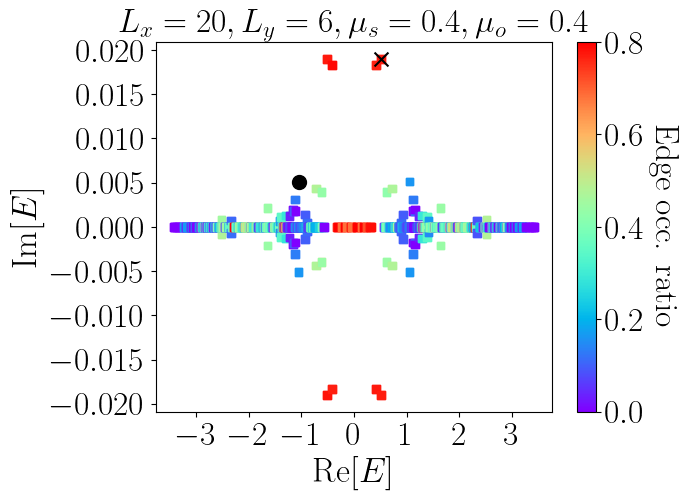

m = 1.1777777777777778, gamma = 0.044444444444444446, imE_max_bulk = 0.005113729622925637, imE_max_topo = 0.018985815294734837, imE_diff = 0.0138720856718092
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


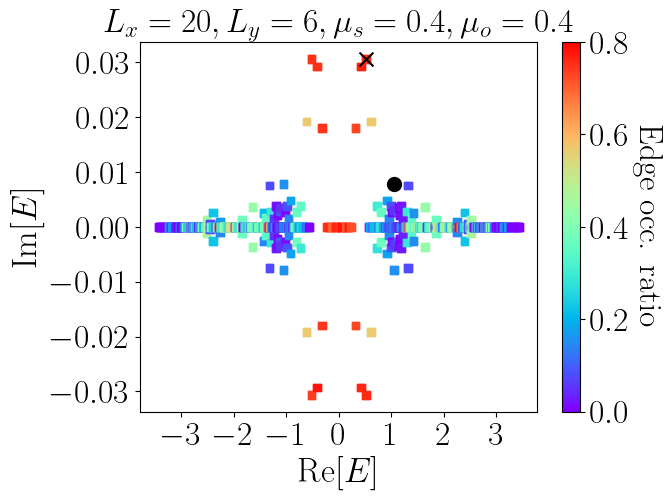

m = 1.1777777777777778, gamma = 0.06666666666666667, imE_max_bulk = 0.007818276838372076, imE_max_topo = 0.030646309517947088, imE_diff = 0.022828032679575012
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


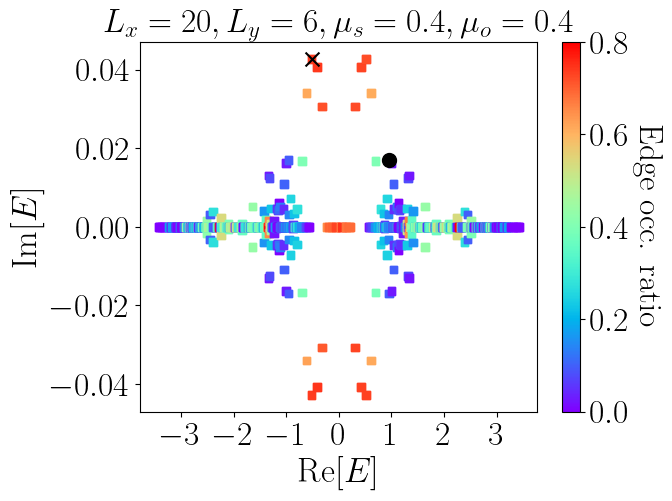

m = 1.1777777777777778, gamma = 0.08888888888888889, imE_max_bulk = 0.017007565931780048, imE_max_topo = 0.042793147197748876, imE_diff = 0.02578558126596883
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


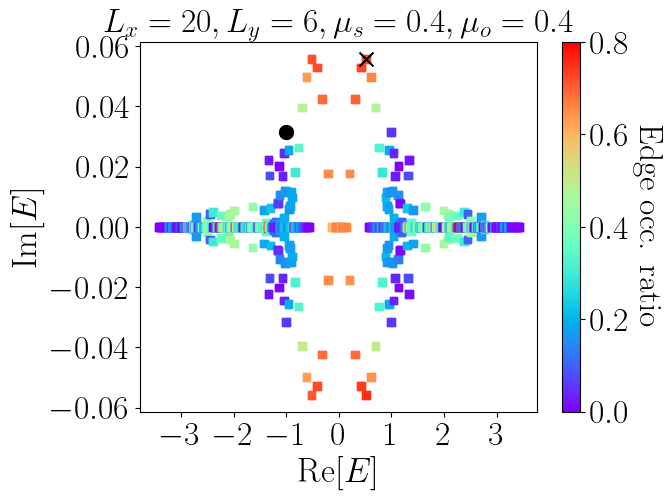

m = 1.1777777777777778, gamma = 0.11111111111111112, imE_max_bulk = 0.03154392083304878, imE_max_topo = 0.055779735703555926, imE_diff = 0.024235814870507147
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


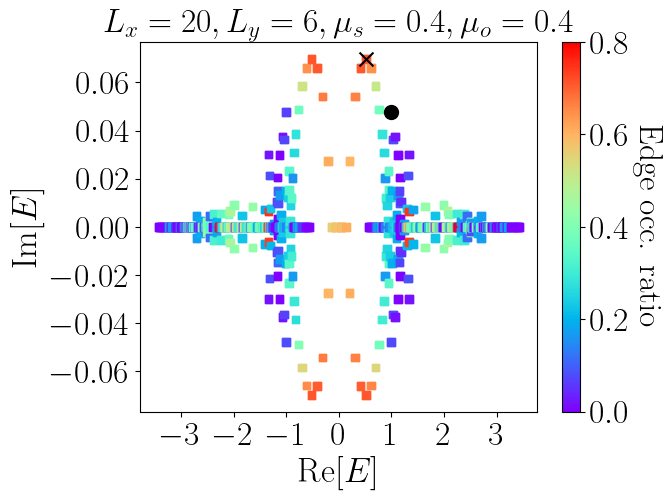

m = 1.1777777777777778, gamma = 0.13333333333333333, imE_max_bulk = 0.04769097034006403, imE_max_topo = 0.06974923077253288, imE_diff = 0.02205826043246885
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


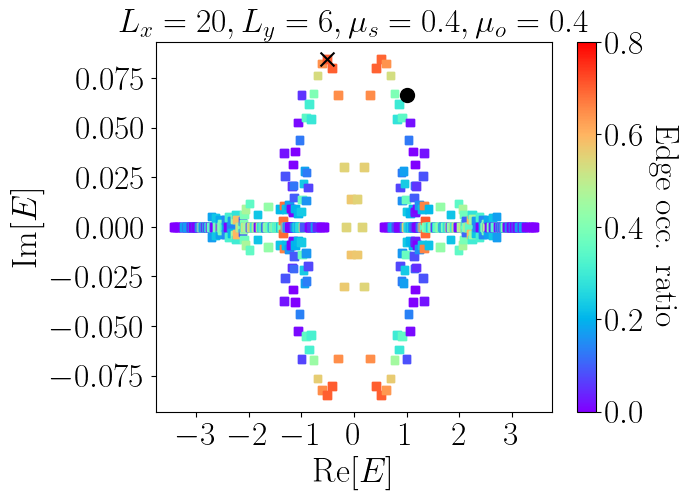

m = 1.1777777777777778, gamma = 0.15555555555555556, imE_max_bulk = 0.06661111626180616, imE_max_topo = 0.08474127903862423, imE_diff = 0.018130162776818073
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


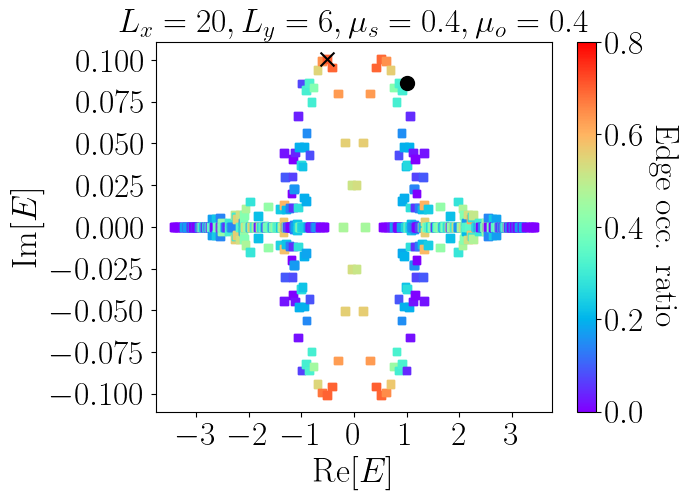

m = 1.1777777777777778, gamma = 0.17777777777777778, imE_max_bulk = 0.08606807224557887, imE_max_topo = 0.10073313965415966, imE_diff = 0.014665067408580784
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


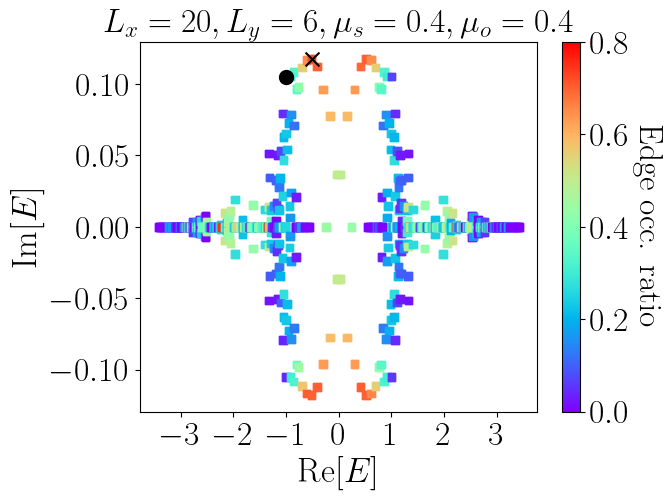

m = 1.1777777777777778, gamma = 0.2, imE_max_bulk = 0.10524601777751373, imE_max_topo = 0.11766718568264145, imE_diff = 0.01242116790512772
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


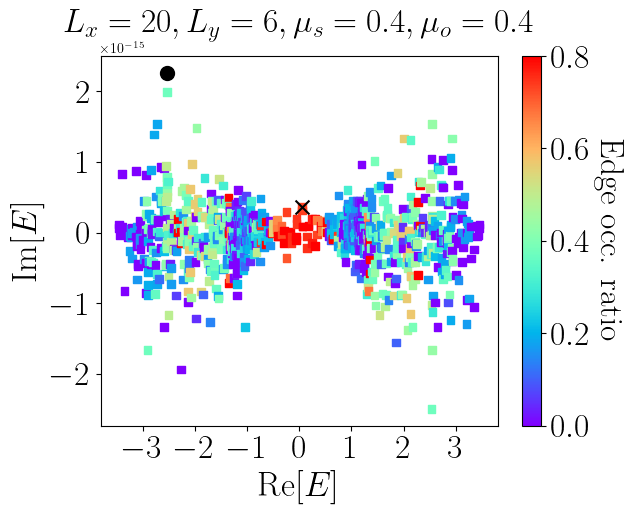

m = 1.2, gamma = 0.0, imE_max_bulk = 2.2595049242015434e-15, imE_max_topo = 3.637473367527146e-16, imE_diff = -1.895757587448829e-15
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


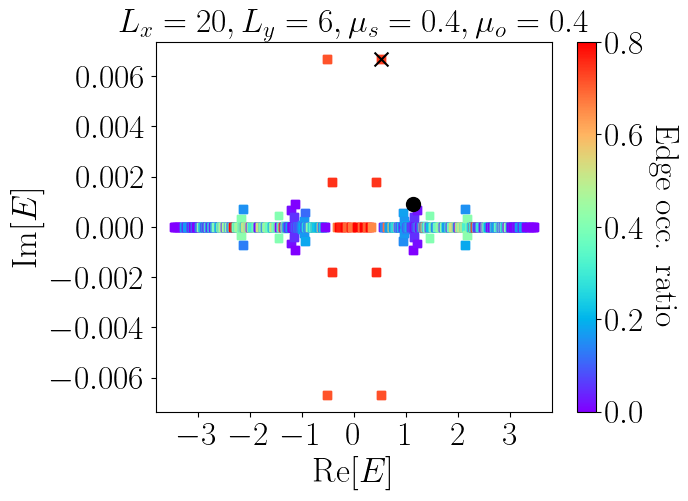

m = 1.2, gamma = 0.022222222222222223, imE_max_bulk = 0.0009093609025847397, imE_max_topo = 0.00667931229521322, imE_diff = 0.005769951392628481
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


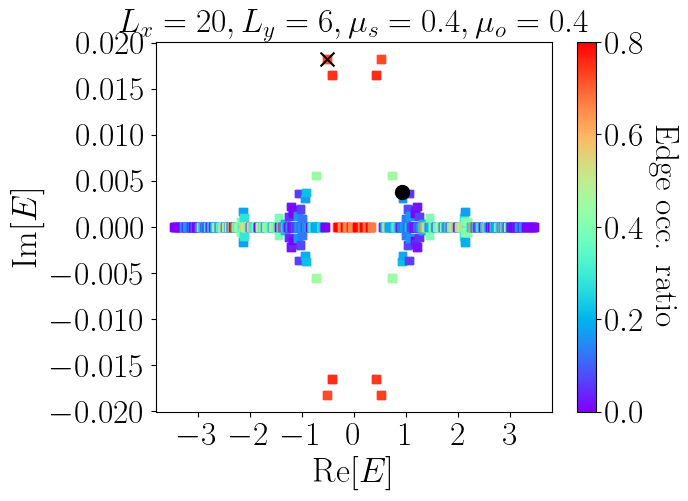

m = 1.2, gamma = 0.044444444444444446, imE_max_bulk = 0.0037446734544361606, imE_max_topo = 0.018233637228778164, imE_diff = 0.014488963774342003
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


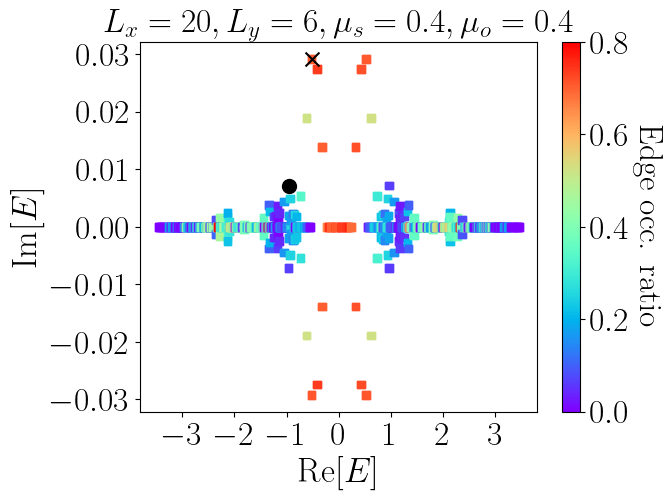

m = 1.2, gamma = 0.06666666666666667, imE_max_bulk = 0.007188810088522152, imE_max_topo = 0.029199063405331023, imE_diff = 0.02201025331680887
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


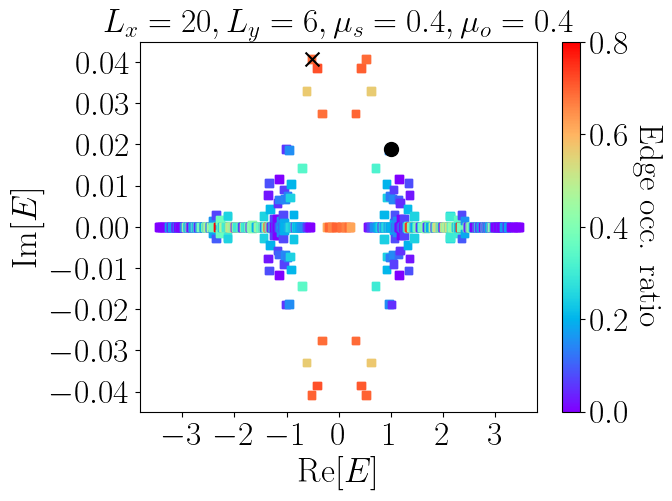

m = 1.2, gamma = 0.08888888888888889, imE_max_bulk = 0.018847496719812954, imE_max_topo = 0.04079160501905205, imE_diff = 0.0219441082992391
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


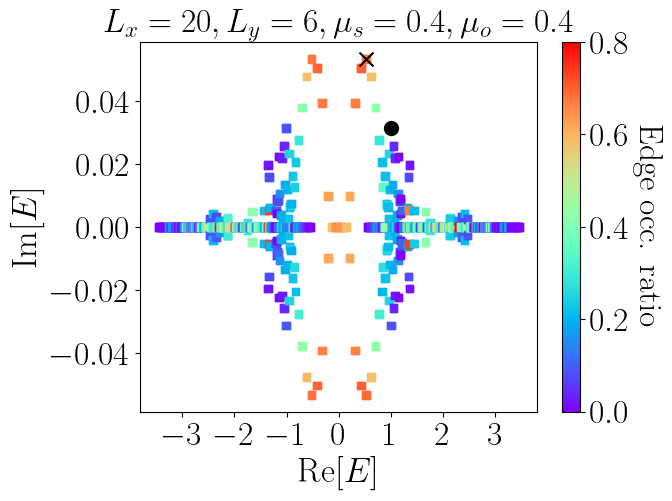

m = 1.2, gamma = 0.11111111111111112, imE_max_bulk = 0.03137181008970681, imE_max_topo = 0.0533334648604246, imE_diff = 0.021961654770717785
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


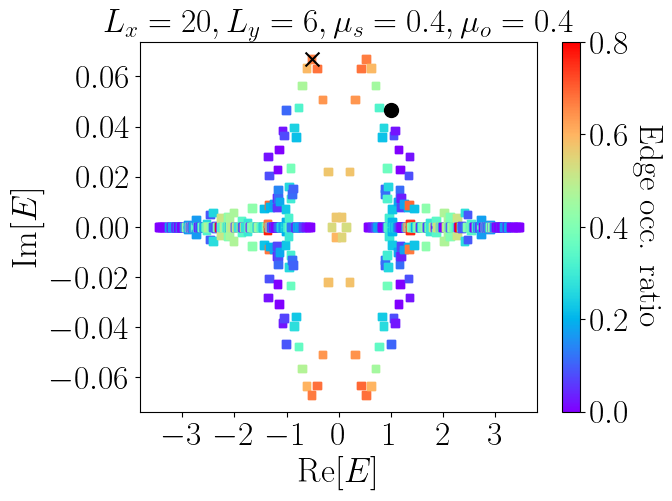

m = 1.2, gamma = 0.13333333333333333, imE_max_bulk = 0.04666459332745977, imE_max_topo = 0.06696696257989969, imE_diff = 0.020302369252439917
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


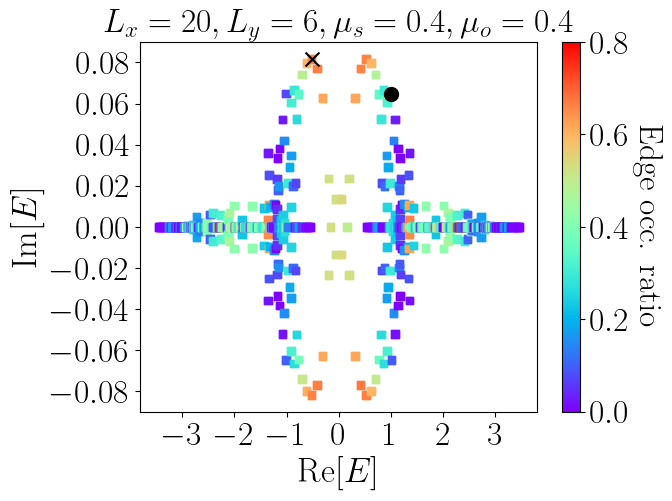

m = 1.2, gamma = 0.15555555555555556, imE_max_bulk = 0.06486587352677654, imE_max_topo = 0.08173046392814669, imE_diff = 0.016864590401370144
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


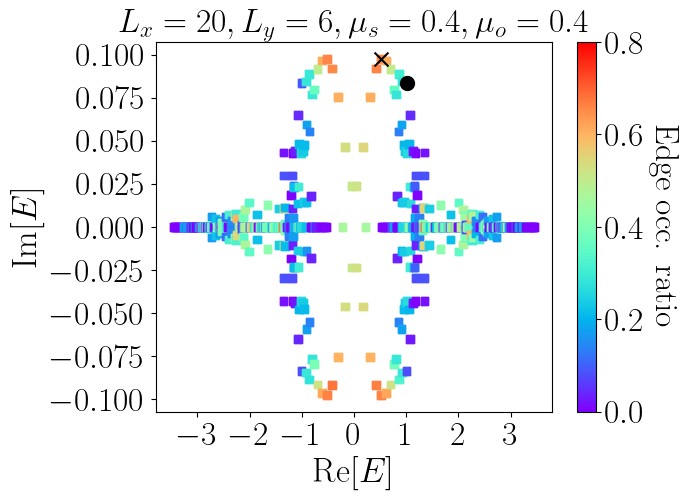

m = 1.2, gamma = 0.17777777777777778, imE_max_bulk = 0.08370829303224933, imE_max_topo = 0.09759314768467839, imE_diff = 0.013884854652429057
Memory usage of dense matrix: 0.007373 GB
Memory usage of dense tensor: 0.014746 GB


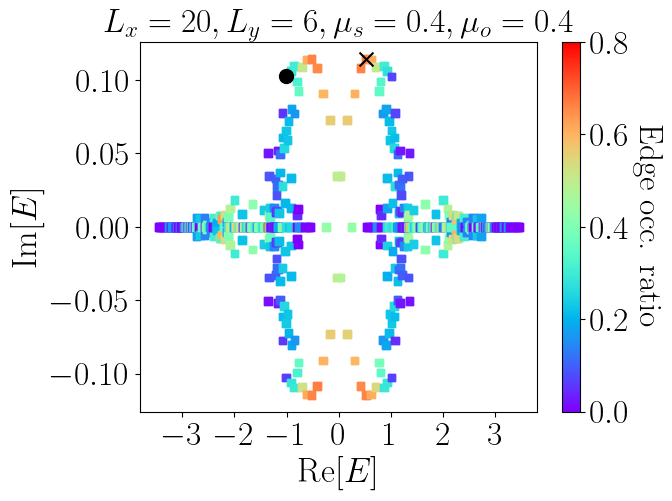

m = 1.2, gamma = 0.2, imE_max_bulk = 0.1025392837857667, imE_max_topo = 0.11448323082790848, imE_diff = 0.011943947042141786


In [4]:
Ts = 0.4
To = 0.4
imE_max_bulk_list = np.zeros((num, num))
imE_max_topo_list = np.zeros((num, num))
imE_diff_list = np.zeros((num, num))
for i in range(num):
    m_vals = m00_vals[i] * np.ones((Ly, Lx))
    for j in range(num):
        gamma = gamma00_vals[j] * np.ones((Ly, Lx))
        imE_max_bulk, imE_max_topo, imE_diff = find_largest_imE(Lx, Ly, t, m_vals, gamma, T, Ts, To)
        imE_max_bulk_list[i, j] = imE_max_bulk
        imE_max_topo_list[i, j] = imE_max_topo
        imE_diff_list[i, j] = imE_diff
        print(f"m = {m00_vals[i]}, gamma = {gamma00_vals[j]}, imE_max_bulk = {imE_max_bulk}, imE_max_topo = {imE_max_topo}, imE_diff = {imE_diff}")

In [5]:
np.save("imE_max_bulk_list_4layer_phase.npy", imE_max_bulk_list)
np.save("imE_max_topo_list_4layer_phase.npy", imE_max_topo_list)
np.save("imE_diff_list_4layer_phase.npy", imE_diff_list)

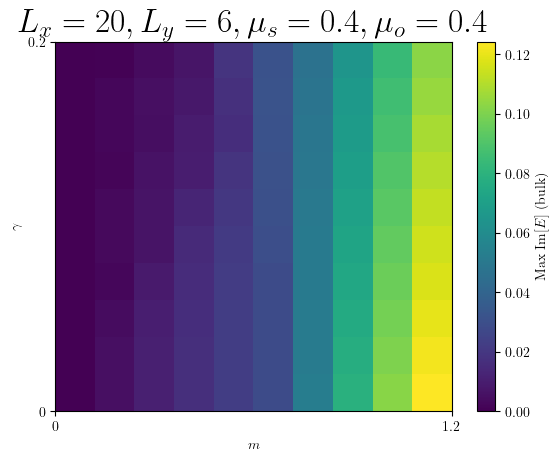

In [13]:
# plot the imE_max_bulk_list and imE_max_topo_list, plot m-1 boundary 

plt.figure()
plt.imshow(imE_max_bulk_list, aspect='auto', origin='lower', extent=[0, num, 0, num])
plt.colorbar(label='Max Im[$E$] (bulk)', orientation='vertical')
plt.xlabel(r'$m$')
plt.ylabel(r'$\gamma$')
plt.title(rf'$L_x={Lx}, L_y={Ly}, \mu_s = {np.round(Ts,3)}, \mu_o={np.round(To,3)}$', fontsize=24)
plt.xticks([0, num], ['0', 1.2])
plt.yticks([0, num], ['0', 0.2])
plt.show()


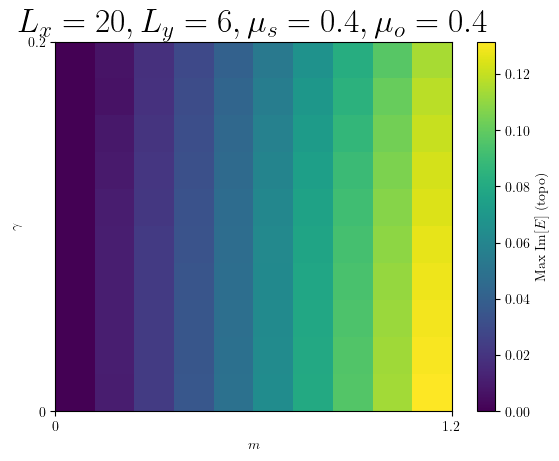

In [14]:
# plot the imE_max_bulk_list and imE_max_topo_list, plot m-1 boundary 

plt.figure()
plt.imshow(imE_max_topo_list, aspect='auto', origin='lower', extent=[0, num, 0, num])
plt.colorbar(label='Max Im[$E$] (topo)', orientation='vertical')
plt.xlabel(r'$m$')
plt.ylabel(r'$\gamma$')
plt.title(rf'$L_x={Lx}, L_y={Ly}, \mu_s = {np.round(Ts,3)}, \mu_o={np.round(To,3)}$', fontsize=24)
plt.xticks([0, num], ['0', 1.2])
plt.yticks([0, num], ['0', 0.2])
plt.show()


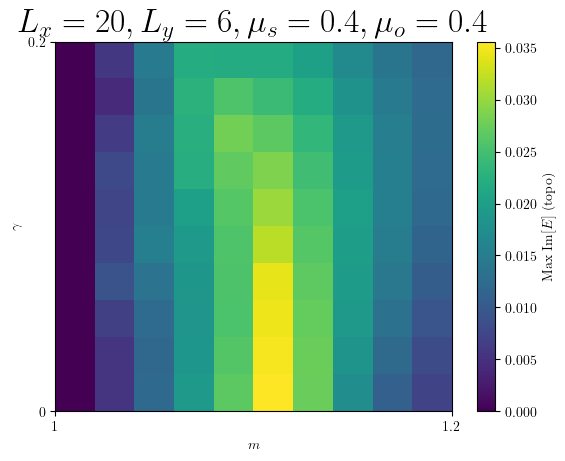

In [17]:
plt.figure()
plt.imshow(imE_diff_list, aspect='auto', origin='lower', extent=[0, num, 0, num])
plt.colorbar(label='Max Im[$E$] (topo)', orientation='vertical')
plt.xlabel(r'$m$')
plt.ylabel(r'$\gamma$')
plt.title(rf'$L_x={Lx}, L_y={Ly}, \mu_s = {np.round(Ts,3)}, \mu_o={np.round(To,3)}$', fontsize=24)
plt.xticks([0, num], ['1', 1.2])
plt.yticks([0, num], ['0', 0.2])
plt.show()